<a href="https://colab.research.google.com/github/arpanbiswas52/PaperNotebooks/blob/main/films_PZO_GPexplore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Supplement of Paper Tilted:**

<h1>Effect of surface ionic screening on polarization reversal and phase diagrams in thin antiferroelectric films for energy and information storage

Anna N. Morozovska , Eugene A. Eliseev, Arpan Biswas,  Nicholas V. Morozovsky, and Sergei V. Kalinin

- Formulation of Objective function to define phases to illustrate Table 1, Code for GP exploration (GPyTorch), Colab Workflow -- *Arpan Biswas*


In [ ]:
!pip install botorch #version 0.4.0
!pip install gpytorch #version 1.4.0

     |████████████████████████████████| 399kB 3.9MB/s 
     |████████████████████████████████| 501kB 33.2MB/s 


In [ ]:
import torch as to #version 1.8.1
import gpytorch as gpt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
import matplotlib.pyplot as plt
import numpy as np #version 1.20.3
from gpytorch.constraints import GreaterThan
import random
from numpy import linalg as LA

from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import sympy as sym #version 1.8

In [ ]:
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [ ]:
# For quick analysis of the order parameters and Free Energy plots
def AFIsystem(T, rho, h, dG, w):

    alpha_pt = 2.7969*10**5
    alpha_at = 4.8789*10**6
    Tp = 463.2
    Ta = 490
    beta_p = 3.825*10**8
    beta_a = 2.056*10**9
    xhi = 1.7754*10**10
    #gamma_p = 3.126*10**9
    #gamma_a = 2.28*10**10
    gamma_p = 0
    gamma_a = 0
    h=h*10**-9
    epsilon_b = 7
    l_da = 2*10**-9
    epsilon_d = 10
    epsilon_0 = 8.85*10**-12
    charge = 1.6*10**-19
    Z = [2, -2]
    n = [2, -2]
    Ai = [10**-18, 10**-18]
    kb = 1.38*10**-23
    delta_G = dG*charge
    U= 7

    f1 = (1+ np.exp(delta_G/(kb*T))*rho**(1/n[0]))**(-1)
    f2 = (1+ np.exp(delta_G/(kb*T))*rho**(1/n[1]))**(-1)
    screen = ((l_da*h)/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))*(((charge*Z[0]*f1)**2/(Ai[0]*kb*T)) + ((charge*Z[1]*f2)**2/(Ai[1]*kb*T)))
    Esi = (l_da/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))*(((charge*Z[0]*f1)/Ai[0]) + ((charge*Z[1]*f1)/Ai[1]))
    Ea = -(epsilon_d*U)/((epsilon_d*h) + (l_da*epsilon_b))
    Eff = 0
    alpha_p = alpha_pt*(T-Tp)
    alpha_a = alpha_at*(T-Ta)
    alpha_pr = alpha_p*(1+screen)+ ((l_da*0.5)/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))
    beta_pr = (1+screen)*beta_p
    gamma_pr = (1+screen)*gamma_p
    xhi_r = (1+screen)*xhi
    P, A = sym.symbols('P A')

    En = alpha_pr*P**2 + beta_pr*P**4 + gamma_pr*P**6 -Eff*P + xhi_r*P**2*A**2 + alpha_a*A**2 + beta_a*A**4 + gamma_a*A**6
    dEn_dP = sym.diff(En, P)
    dEn_dA = sym.diff(En, A)
    solPA = sym.solve((dEn_dP, dEn_dA),(P, A))

    #objeval = getobj(solPA, w)
    m=0
    sol=np.zeros((1,2))
    solEn = np.zeros((1))
    for i in range(0,len(solPA)):
        s = solPA[i]
        if ((np.absolute(sym.im(s[0]))<=1e-10) and ((np.absolute(sym.im(s[1]))<=1e-10))): #solution exist
            sEn = alpha_pr*s[0]**2 + beta_pr*s[0]**4 + gamma_pr*s[0]**6 -Eff*s[0] + xhi_r*s[0]**2*s[1]**2 + alpha_a*s[1]**2 + beta_a*s[1]**4 + gamma_a*s[1]**6
            if (m==0):
                sol[m,:]=s
                solEn[m] = sEn
            else:
                sol =np.vstack((sol,s))
                solEn = np.vstack((solEn,sEn))       
            m=m+1
        else: #solution does not exist
            m=m
      


    return solEn, sol, solPA

# For Phase diagram using GP, computed objective function from order parameters to define different phases
def AFIsystem2(T, rho, h, dG, w):

    alpha_pt = 2.7969*10**5
    alpha_at = 4.8789*10**6
    Tp = 463.2
    Ta = 490
    beta_p = 3.825*10**8
    beta_a = 2.056*10**9
    xhi = 1.7754*10**10
    #gamma_p = 3.126*10**9
    #gamma_a = 2.28*10**10
    gamma_p = 0
    gamma_a = 0
    h=h*10**-9
    epsilon_b = 7
    l_da = 2*10**-9
    epsilon_d = 10
    epsilon_0 = 8.85*10**-12
    charge = 1.6*10**-19
    Z = [2, -2]
    n = [2, -2]
    Ai = [10**-18, 10**-18]
    kb = 1.38*10**-23
    delta_G = dG*charge
    U= 7

    f1 = (1+ np.exp(delta_G/(kb*T))*rho**(1/n[0]))**(-1)
    f2 = (1+ np.exp(delta_G/(kb*T))*rho**(1/n[1]))**(-1)
    screen = ((l_da*h)/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))*(((charge*Z[0]*f1)**2/(Ai[0]*kb*T)) + ((charge*Z[1]*f2)**2/(Ai[1]*kb*T)))
    Esi = (l_da/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))*(((charge*Z[0]*f1)/Ai[0]) + ((charge*Z[1]*f1)/Ai[1]))
    Ea = -(epsilon_d*U)/((epsilon_d*h) + (l_da*epsilon_b))
    Eff = 0
    alpha_p = alpha_pt*(T-Tp)
    alpha_a = alpha_at*(T-Ta)
    alpha_pr = alpha_p*(1+screen)+ ((l_da*0.5)/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))
    beta_pr = (1+screen)*beta_p
    gamma_pr = (1+screen)*gamma_p
    xhi_r = (1+screen)*xhi
    P, A = sym.symbols('P A')

    En = alpha_pr*P**2 + beta_pr*P**4 + gamma_pr*P**6 -Eff*P + xhi_r*P**2*A**2 + alpha_a*A**2 + beta_a*A**4 + gamma_a*A**6
    dEn_dP = sym.diff(En, P)
    dEn_dA = sym.diff(En, A)
    solPA = sym.solve((dEn_dP, dEn_dA),(P, A))

    #Calculate 2nd derivative and Hessian Matrix
    H=np.zeros((2,2))
    d2En_dP2 = sym.diff(dEn_dP, P)
    d2En_dA2 = sym.diff(dEn_dA, A)
    d2En_dPdA = sym.diff(dEn_dP, A)
    d2En_dAdP = sym.diff(dEn_dA, P)

    #objeval = getobj(solPA, w)

    m=0
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    M=1000
    sol=np.zeros((1,2))
    solEn = np.zeros((1))
    for i in range(0,len(solPA)):
        s = solPA[i]
        if ((np.absolute(sym.im(s[0]))<=1e-10) and ((np.absolute(sym.im(s[1]))<=1e-10))): #solution exist
            sEn = alpha_pr*s[0]**2 + beta_pr*s[0]**4 + gamma_pr*s[0]**6 -Eff*s[0] + xhi_r*s[0]**2*s[1]**2 + alpha_a*s[1]**2 + beta_a*s[1]**4 + gamma_a*s[1]**6
            H[0, 0] = d2En_dP2.subs(P, s[0]).subs(A, s[1])
            H[1, 1] = d2En_dA2.subs(P, s[0]).subs(A, s[1])
            H[0, 1] = d2En_dPdA.subs(P, s[0]).subs(A, s[1])
            H[1, 0] = d2En_dAdP.subs(P, s[0]).subs(A, s[1])
            ei, ev = LA.eig(H)
            if (min(ei)>0): #hessian positive definite, necessary cond for local minima

                if (m==0):
                    sol[m,:]=s
                    solEn[m] = sEn
                else:
                    sol =np.vstack((sol,s))
                    solEn = np.vstack((solEn,sEn))
                m=m+1
            else: #hessian is not positive semi-definite
                m=m
        else: #solution does not exist
            m=m

    #Compute objective values from order parameters, to define phases
    if (m == 1):  # PE
        # if ((sol[:,0]==0) and (sol[:,1]==0)):
        p1 = max(sol[:, 0])
        p2 = max(sol[:, 1])
        if (p1 == 0):
            p1 = 1e-5
        if (p2 == 0):
            p2 = 1e-5
        # p2 = p1
        # a2 = a1
        n1 = 1
        n2 = 1
        #n = n2 ** n1  # 1: P =0 or A=0; 2: P = x or A =x; n=n2^n1
        n=0
        objeval = (-1) ** n * ((np.absolute((np.absolute(p1) - np.absolute(p2)) / max(np.absolute(p1), np.absolute(p2))) * w1 * M) + ((n - 1) * w2 * M))

    elif (m == 2):  # can be AFE or AFI

        if (max(np.absolute(sol[:,0]))==0): #AFE phase, P=0
            p1 = max(sol[:, 0])
            p2 = max(sol[:, 1])
            n1 = 1
            n2 = 2
            n = n2 ** n1
            objeval = (-1) ** n * ((np.absolute((np.absolute(p1) - np.absolute(p2)) / max(np.absolute(p1), np.absolute(p2))) * w1 * M) + ((n - 1) * w2 * M))
        elif ((max(np.absolute(sol[:,1]))==0)):#AFI phase, A =0
            p1 = max(sol[:, 0])
            p2 = max(sol[:, 1])
            n1 = 1
            n2 = 2
            n = n2 ** n1
            objeval = (-1) ** n * ((np.absolute((np.absolute(p1) - np.absolute(p2)) / max(np.absolute(p1), np.absolute(p2))) * w1 * M) + ((n - 1) * w2 * M))

    elif (m == 4): #FEI

        p1 = max(sol[:, 0])
        p2 = max(sol[:, 1])
        n1 = 2
        n2 = 2
        n = n2 ** n1
        objeval = (-1) ** n * ((np.absolute((np.absolute(p1) - np.absolute(p2)) / max(np.absolute(p1), np.absolute(p2))) * w1 * M) + ((n - 1) * w2 * M) + ((solEn[1] - solEn[0] )/ max(np.absolute(solEn[0]), np.absolute(solEn[1])) * w3 * M))

    return objeval, sol

def plot_exploration_results3D(X1, X2, test_y, Gp_y_mu, Gp_y_var, train_X, train_Y, iter):
    _, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 6))
    ax1.imshow(X1, origin='bottom', cmap='nipy_spectral')
    ax2.imshow(X2, origin='bottom', cmap='nipy_spectral')
    ax3.imshow(test_y.detach().numpy(), origin='bottom', cmap='nipy_spectral')
    ax4.imshow(Gp_y_mu.detach().numpy(), origin='bottom', cmap='nipy_spectral')
    ax5.imshow(Gp_y_var.detach().numpy(), origin='bottom', cmap='nipy_spectral')
    ax1.set_title('T')
    #ax2.set_title('E')
    ax2.set_title('rho')
    ax3.set_title('True func eval')
    ax4.set_title("GP prediction, iter=" + str(iter))
    ax5.set_title("Uncertainty, iter=" + str(iter))
    plt.show()
    # plt.colorbar()

    fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
    ax.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, cmap='viridis', linewidth=0.2)
    #ax.set_title('T-Tc vs E vs true_f at iter =' + str(i))
    ax.set_title('T vs rho vs true_f at iter =' + str(i))


    fig2, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
    axs.axs1 = plt.axes(projection='3d')
    axs.axs1.scatter3D(train_X[:, 0], train_X[:, 1], train_Y, c=train_Y, cmap='viridis')
    #ax.set_title('T-Tc vs E vs true_f at iter =' + str(i))
    axs.axs1.set_title('T vs rho vs true_f at iter =' + str(i))
    plt.show()

<h1>Defination of different phases in terms of objective function value

**PE**: minimal function value with $f=-w_2M$ where $w_1<w_2$

**AFI**: function value increases than PE phase with $f=-w_1M$ where $w_1<w_2$

**AFE**: function value increases than above two phases with $f=w_1M + w_2M$

**FEI**: maximum function value with $f=x_1w_1M + 3w_2M +x_2w_3M$ where $0\leq x_1\leq 1, -1\leq x_2\leq 1$

**In the FEI phase, objective value will be greater when P solutions will have deeper wells** on min energy (depper minima) than A solutions than the vice versa.

$M$ is a large positive number
 
$w_1 + w_2 + w_3=1$


[[-4946563.037463518]
 [-87963.3744571394]
 [-87963.3744571394]
 [-12228901.4484740]
 [0]
 [-12228901.4484740]
 [-87963.3744571394]
 [-87963.3744571394]
 [-4946563.03746352]]
[[-0.0804845188665055 0.0]
 [-0.00759937532973021 -0.0166322257014702]
 [-0.00759937532973021 0.0166322257014702]
 [0.0 -0.277709721991716]
 [0.0 0.0]
 [0.0 0.277709721991716]
 [0.00759937532973021 -0.0166322257014702]
 [0.00759937532973021 0.0166322257014702]
 [0.0804845188665055 0.0]]
[(-0.0804845188665055, 0.0), (-0.00759937532973021, -0.0166322257014702), (-0.00759937532973021, 0.0166322257014702), (0.0, -0.277709721991716), (0.0, 0.0), (0.0, 0.277709721991716), (0.00759937532973021, -0.0166322257014702), (0.00759937532973021, 0.0166322257014702), (0.0804845188665055, 0.0)]


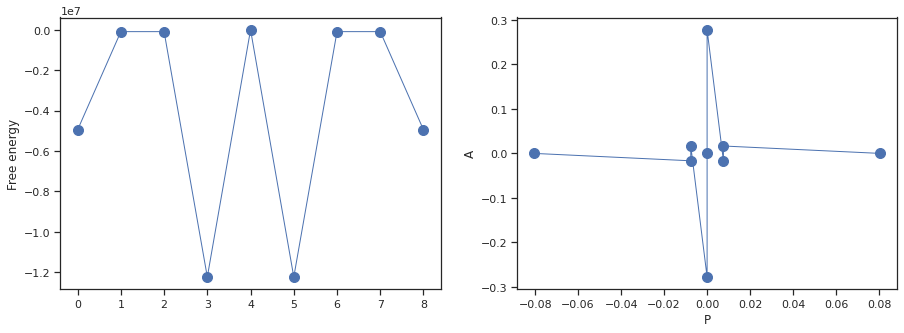

In [ ]:
# Manual analysis for combination of T, rho, h and dG
#Plotting with show the energy at each stationary points of A, P (solving dEn/dp =0 and dEn/dA =0)
w = [0.3, 0.7]
solEn, sol, solPA = AFIsystem(425, 10**6, 5, 0.02, w)
print(solEn)
print(sol)
print(solPA)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(solEn,'o-', linewidth=1, markersize= 10)
ax[0].set_ylabel('Free energy')
ax[1].plot(sol[:,0], sol[:,1],'o-', linewidth=1, markersize= 10)
ax[1].set_xlabel('P')
ax[1].set_ylabel('A')
plt.show()

<h1> Analysis 1

$E=0, \gamma_{a,p}=0, h=50 nm, dG_1 = dG_2 = 0.2 eV$

Parameter space over $T$ and $\rho$

$T=[300, 520], \rho =[10^1, 10^6]$

Lattice site #1
Lattice site #2
Lattice site #3
Lattice site #4
Lattice site #5
Lattice site #6
Lattice site #7
Lattice site #8
Lattice site #9
Lattice site #10
Lattice site #11
Lattice site #12
Lattice site #13
Lattice site #14
Lattice site #15
Lattice site #16
Lattice site #17
Lattice site #18
Lattice site #19
Lattice site #20
Lattice site #21
Lattice site #22
Lattice site #23
Lattice site #24
Lattice site #25
Lattice site #26
Lattice site #27
Lattice site #28
Lattice site #29
Lattice site #30
Lattice site #31
Lattice site #32
Lattice site #33
Lattice site #34
Lattice site #35
Lattice site #36
Lattice site #37
Lattice site #38
Lattice site #39
Lattice site #40
Lattice site #41
Lattice site #42
Lattice site #43
Lattice site #44
Lattice site #45
Lattice site #46
Lattice site #47
Lattice site #48
Lattice site #49
Lattice site #50
Lattice site #51
Lattice site #52
Lattice site #53
Lattice site #54
Lattice site #55
Lattice site #56
Lattice site #57
Lattice site #58
Lattice site #59
Lattic

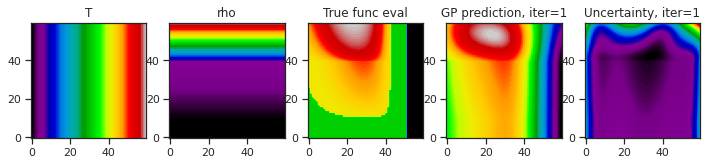

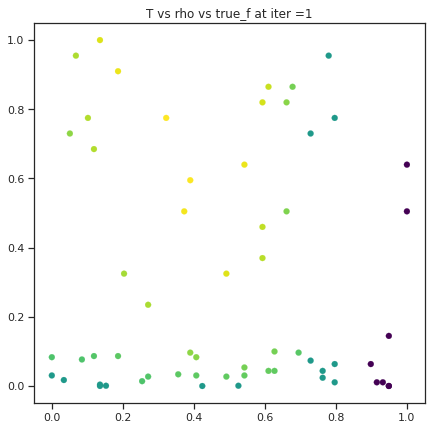

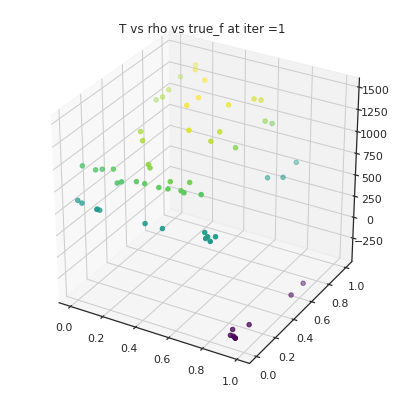

Model training:
Iteration:10
Loss:20458.422971431395
noise:1.7936481368077528
Model training:
Iteration:20
Loss:13935.175087516767
noise:2.648530727833885
Model training:
Iteration:30
Loss:10124.88930687493
noise:3.2066574309072062
Model training:
Iteration:40
Loss:8556.827024470042
noise:3.595129597306877
Model training:
Iteration:50
Loss:7843.273560242242
noise:3.9038814250940526
Model training:
Iteration:60
Loss:7283.463588991395
noise:4.1736385234398305
Model training:
Iteration:70
Loss:6851.192345783251
noise:4.4186227870941455
Model training:
Iteration:80
Loss:6508.772718108755
noise:4.645391155586349
Model training:
Iteration:90
Loss:6213.091228567759
noise:4.859044539917871
Model training:
Iteration:100
Loss:5953.560231738948
noise:5.063800089150163
Model training:
Iteration:110
Loss:5723.724455505607
noise:5.2619549849923075
Model training:
Iteration:120
Loss:5517.494350681819
noise:5.454311412195122
Model training:
Iteration:130
Loss:5331.035949569571
noise:5.64119866608923
M

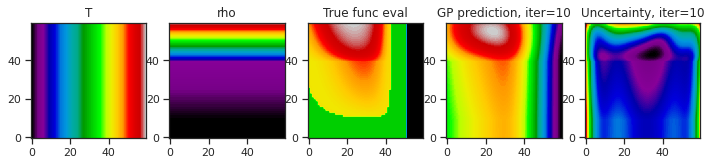

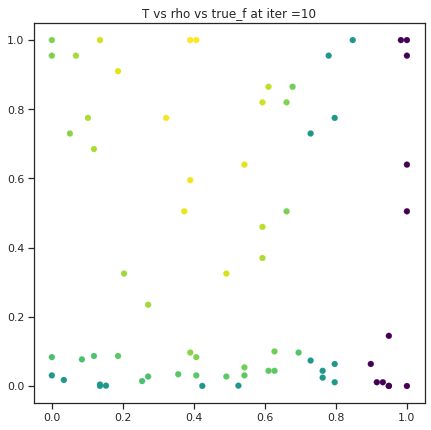

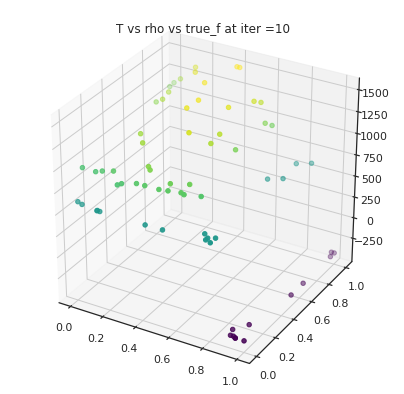

Model training:
Iteration:10
Loss:19192.174682091954
noise:1.7853735632751733
Model training:
Iteration:20
Loss:13102.995175623266
noise:2.652624667775512
Model training:
Iteration:30
Loss:9618.377628524016
noise:3.2321421738429708
Model training:
Iteration:40
Loss:7992.601189850252
noise:3.634289176639893
Model training:
Iteration:50
Loss:7311.591952995449
noise:3.9527213965025485
Model training:
Iteration:60
Loss:6806.963247846122
noise:4.232788787503252
Model training:
Iteration:70
Loss:6399.596709631235
noise:4.4885750296247435
Model training:
Iteration:80
Loss:6077.19470527621
noise:4.725758935873498
Model training:
Iteration:90
Loss:5802.5827980254635
noise:4.949339146446451
Model training:
Iteration:100
Loss:5560.505959986937
noise:5.163031639311474
Model training:
Iteration:110
Loss:5345.917838257539
noise:5.369103996486119
Model training:
Iteration:120
Loss:5153.5810672148455
noise:5.568817317422387
Model training:
Iteration:130
Loss:4979.647637399226
noise:5.762744194226232
M

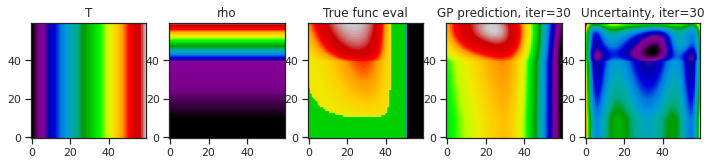

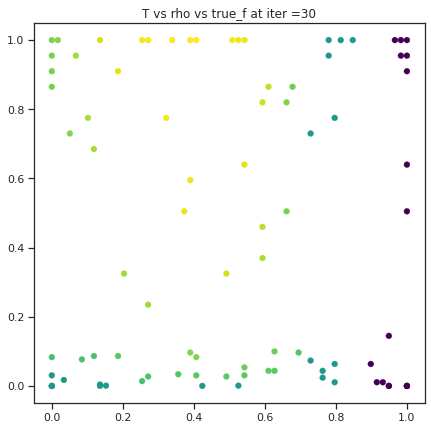

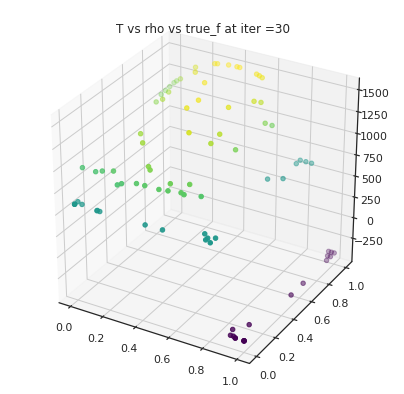

Model training:
Iteration:10
Loss:15813.37481156584
noise:1.7690217133603872
Model training:
Iteration:20
Loss:11040.895397235701
noise:2.6215708957927677
Model training:
Iteration:30
Loss:8166.007061807435
noise:3.1995482542247924
Model training:
Iteration:40
Loss:6717.623933088191
noise:3.600657931783126
Model training:
Iteration:50
Loss:6048.102589726478
noise:3.915086480729987
Model training:
Iteration:60
Loss:5654.16197073443
noise:4.191899993576633
Model training:
Iteration:70
Loss:5323.21330925093
noise:4.449041254439431
Model training:
Iteration:80
Loss:5050.244926687885
noise:4.690472198196256
Model training:
Iteration:90
Loss:4821.828176418918
noise:4.918206988396228
Model training:
Iteration:100
Loss:4621.911534820776
noise:5.13499231122369
Model training:
Iteration:110
Loss:4443.856194912959
noise:5.343306195713333
Model training:
Iteration:120
Loss:4284.133695171593
noise:5.544714446237873
Model training:
Iteration:130
Loss:4139.791935038221
noise:5.740061021950478
Model t

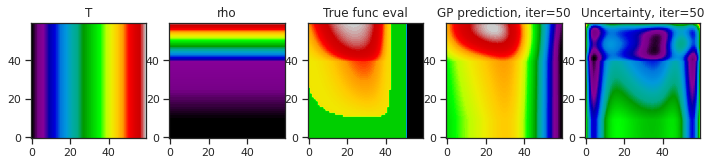

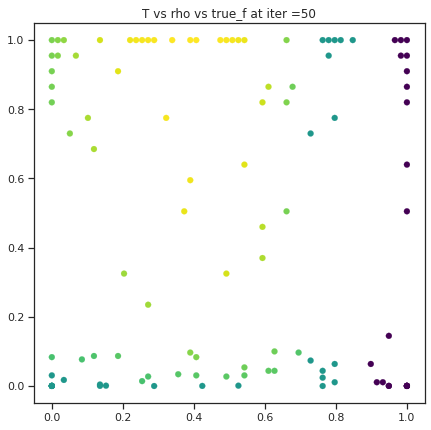

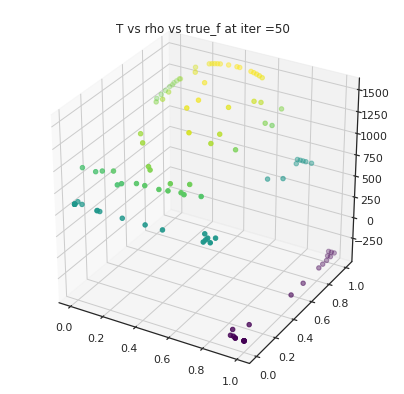

Model training:
Iteration:10
Loss:13465.084537530902
noise:1.7708868795856796
Model training:
Iteration:20
Loss:9462.142987526508
noise:2.6274536248124916
Model training:
Iteration:30
Loss:7026.850858451881
noise:3.209384014888313
Model training:
Iteration:40
Loss:5769.7658948464095
noise:3.6137623678472224
Model training:
Iteration:50
Loss:5166.25037659797
noise:3.930211432698142
Model training:
Iteration:60
Loss:4829.32466708518
noise:4.208196725215274
Model training:
Iteration:70
Loss:4550.492392682883
noise:4.466774464348471
Model training:
Iteration:80
Loss:4316.65422786643
noise:4.710265666641396
Model training:
Iteration:90
Loss:4121.081902899061
noise:4.940278192963336
Model training:
Iteration:100
Loss:3950.4230791168366
noise:5.159161349000217
Model training:
Iteration:110
Loss:3798.427553721125
noise:5.3692829085716856
Model training:
Iteration:120
Loss:3661.977395026692
noise:5.572272581077533
Model training:
Iteration:130
Loss:3538.656105408671
noise:5.769055776561342
Mode

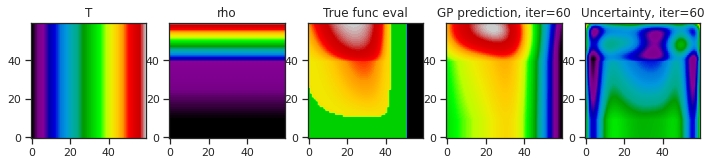

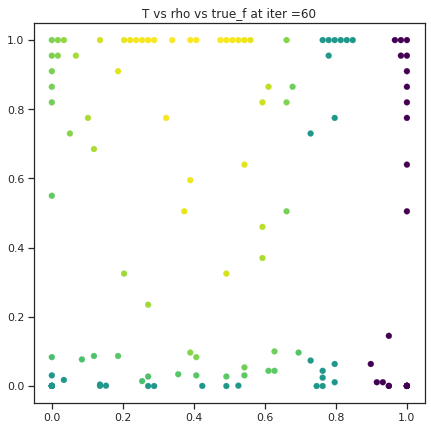

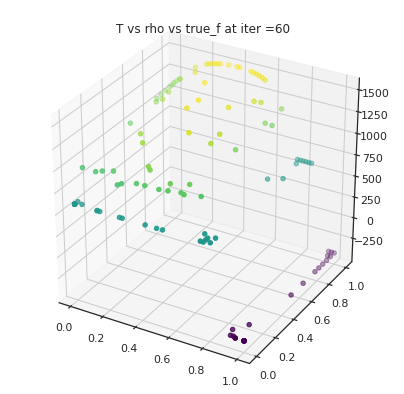

Model training:
Iteration:10
Loss:13025.828572006265
noise:1.786922534523908
Model training:
Iteration:20
Loss:9046.929017141054
noise:2.673012580961115
Model training:
Iteration:30
Loss:6798.585836921131
noise:3.272518621247524
Model training:
Iteration:40
Loss:5576.7713439183235
noise:3.6886470168520353
Model training:
Iteration:50
Loss:4991.385088210437
noise:4.01542976757432
Model training:
Iteration:60
Loss:4664.186458983018
noise:4.302799340177756
Model training:
Iteration:70
Loss:4394.6447712628
noise:4.569464794746012
Model training:
Iteration:80
Loss:4169.110035953773
noise:4.820031587308154
Model training:
Iteration:90
Loss:3979.6050498274417
noise:5.056634599749615
Model training:
Iteration:100
Loss:3814.6510607710925
noise:5.281844877421644
Model training:
Iteration:110
Loss:3667.7677630509734
noise:5.497974318378411
Model training:
Iteration:120
Loss:3535.927145810593
noise:5.7065864148982826
Model training:
Iteration:130
Loss:3416.800109230178
noise:5.9086607561634965
Mod

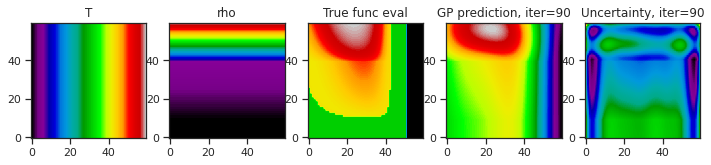

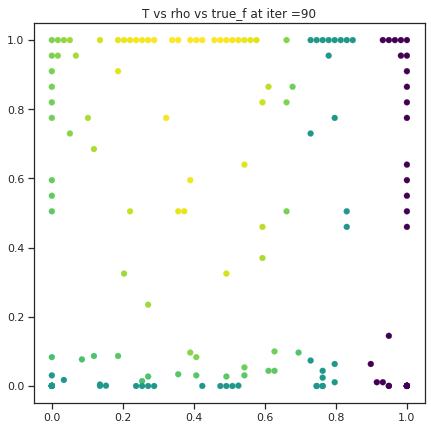

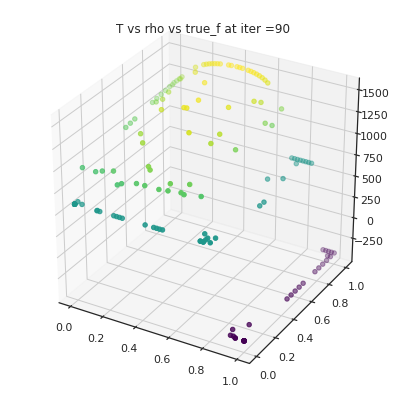

Model training:
Iteration:10
Loss:11874.316680819004
noise:1.819702854231941
Model training:
Iteration:20
Loss:8068.148741785232
noise:2.769860506896808
Model training:
Iteration:30
Loss:6259.70496077458
noise:3.4060619151245564
Model training:
Iteration:40
Loss:5129.516608894211
noise:3.8480183905899144
Model training:
Iteration:50
Loss:4567.669849511006
noise:4.197961855379054
Model training:
Iteration:60
Loss:4245.359520775724
noise:4.504801961136736
Model training:
Iteration:70
Loss:4006.7274755462895
noise:4.787111613986047
Model training:
Iteration:80
Loss:3802.008903610226
noise:5.052309502079249
Model training:
Iteration:90
Loss:3628.0172255493335
noise:5.303864348346598
Model training:
Iteration:100
Loss:3477.1110553388994
noise:5.543764273796832
Model training:
Iteration:110
Loss:3343.301667724963
noise:5.773563375472397
Model training:
Iteration:120
Loss:3223.174310443051
noise:5.994794231309523
Model training:
Iteration:130
Loss:3114.628510646714
noise:6.208739503689065
Mod

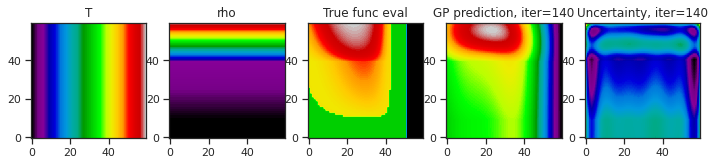

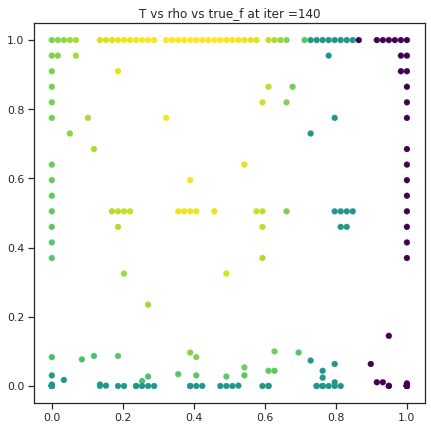

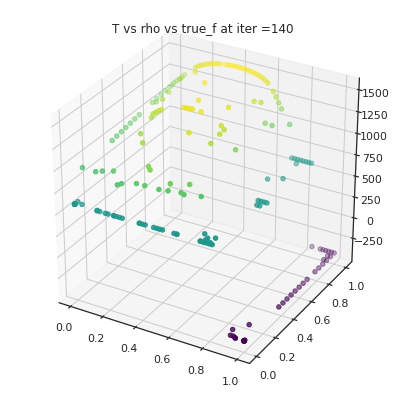

Model training:
Iteration:10
Loss:10377.086150725076
noise:1.8397096048234363
Model training:
Iteration:20
Loss:7218.769836911029
noise:2.8047126777531046
Model training:
Iteration:30
Loss:5559.367196624906
noise:3.4478822937270657
Model training:
Iteration:40
Loss:4610.054360695085
noise:3.904177962418813
Model training:
Iteration:50
Loss:4090.3972753114604
noise:4.266634943442089
Model training:
Iteration:60
Loss:3796.4497377251846
noise:4.5802809353851694
Model training:
Iteration:70
Loss:3582.090090152956
noise:4.868045197545002
Model training:
Iteration:80
Loss:3400.5366124706516
noise:5.139272008179586
Model training:
Iteration:90
Loss:3244.775134956708
noise:5.39666914499546
Model training:
Iteration:100
Loss:3109.486369369761
noise:5.641932489718242
Model training:
Iteration:110
Loss:2989.785841446284
noise:5.876922094463964
Model training:
Iteration:120
Loss:2882.4112047186327
noise:6.103108995961202
Model training:
Iteration:130
Loss:2785.3819492061366
noise:6.321629528036665

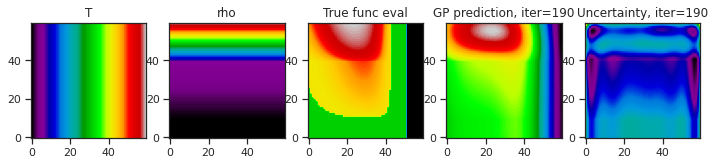

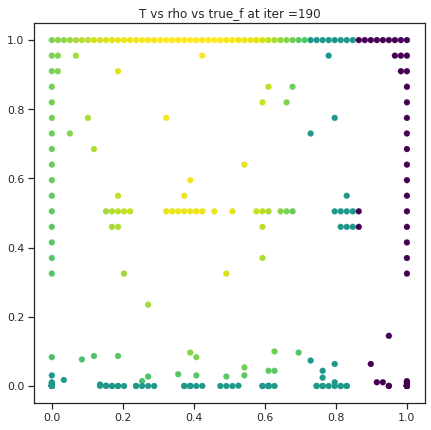

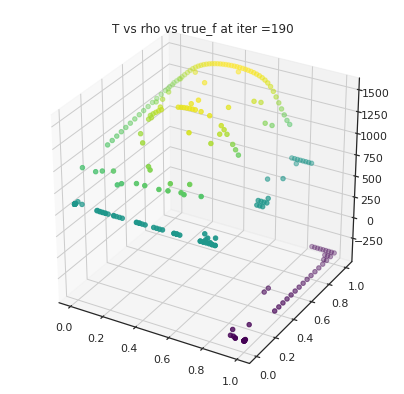

Model training:
Iteration:10
Loss:10008.028248999502
noise:1.8593629511326952
Model training:
Iteration:20
Loss:6892.3415632518345
noise:2.857980808200841
Model training:
Iteration:30
Loss:5412.152599208278
noise:3.5242741263388333
Model training:
Iteration:40
Loss:4530.375528059176
noise:3.9934783482839675
Model training:
Iteration:50
Loss:4029.12683133758
noise:4.363290660833272
Model training:
Iteration:60
Loss:3722.7111792799215
noise:4.6848947545871455
Model training:
Iteration:70
Loss:3505.591251631069
noise:4.982392375591761
Model training:
Iteration:80
Loss:3328.1926910380553
noise:5.264263514225849
Model training:
Iteration:90
Loss:3175.564330768286
noise:5.53303088046789
Model training:
Iteration:100
Loss:3042.117957428344
noise:5.789982062128083
Model training:
Iteration:110
Loss:2924.0247169818967
noise:6.036154433089917
Model training:
Iteration:120
Loss:2818.4284281576943
noise:6.272629609748113
Model training:
Iteration:130
Loss:2723.1575218504577
noise:6.500563590861437

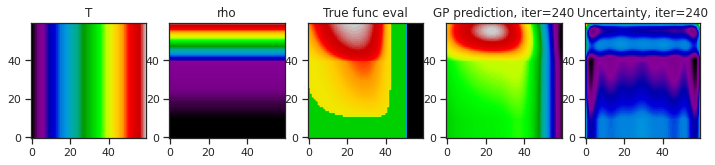

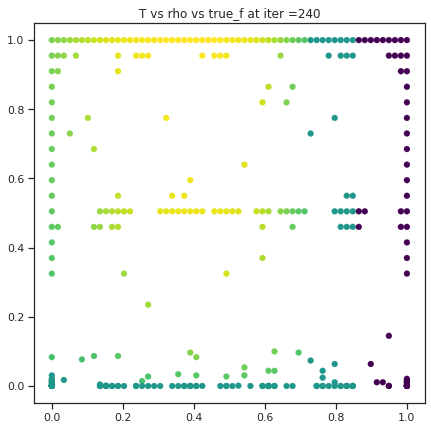

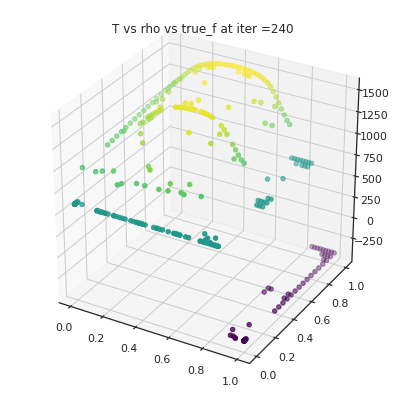

Model training:
Iteration:10
Loss:9443.569149477598
noise:1.8665536735293693
Model training:
Iteration:20
Loss:6426.071336272026
noise:2.880451156634564
Model training:
Iteration:30
Loss:5128.1748815385445
noise:3.556844812474126
Model training:
Iteration:40
Loss:4336.65635966386
noise:4.028185325093083
Model training:
Iteration:50
Loss:3856.537974512825
noise:4.397421960419318
Model training:
Iteration:60
Loss:3549.004526178493
noise:4.719700912333738
Model training:
Iteration:70
Loss:3332.6230923589887
noise:5.018719050906235
Model training:
Iteration:80
Loss:3161.8960120495976
noise:5.3029466252298745
Model training:
Iteration:90
Loss:3016.7728242146272
noise:5.5752278420312615
Model training:
Iteration:100
Loss:2889.7551282104982
noise:5.8364541743953895
Model training:
Iteration:110
Loss:2777.2743998711503
noise:6.087174212923017
Model training:
Iteration:120
Loss:2676.730936849238
noise:6.328197233801211
Model training:
Iteration:130
Loss:2586.093717391734
noise:6.560462860580067

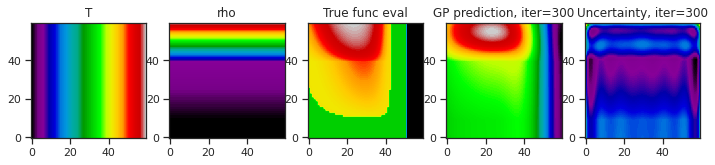

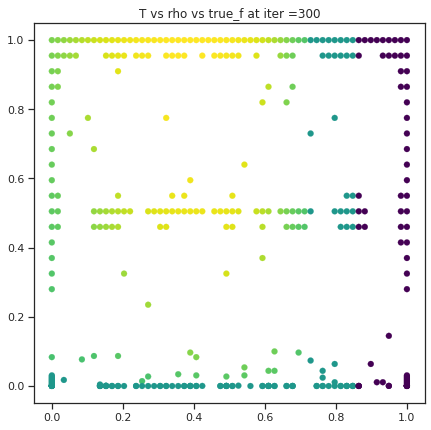

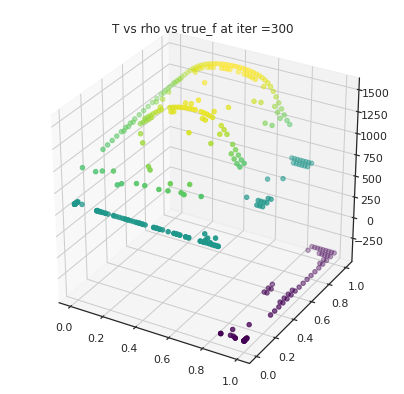

0.26332372
2.8109798


In [ ]:
w = [0.2, 0.4, 0.4]
# testresult = AFIsystem(350, 10**2, 50, 0.2, w)
# print(testresult)


num_rows = 60
num_rows1 = 10
num_rows2 = 31
num_rows3 = 21
num = 60  # Starting samples
N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
N = int(N)
T = np.linspace(300, 520, num_rows)
rho1 = np.linspace(10 ** 1, 10 ** 3, num_rows1)
rho2 = np.delete(np.linspace(10 ** 3, 10 ** 5, num_rows2),0)
rho3 = np.delete(np.linspace(10 ** 5, 10 ** 6 , num_rows3),0)
rho = np.hstack((rho1, rho2, rho3))
minT = min(T)
maxT = max(T)
minrho = min(rho)
maxrho = max(rho)
T, rho = np.meshgrid(T, rho)
T_norm = (T-minT)/(maxT-minT)
rho_norm = (rho-minrho)/(maxrho-minrho)
# Below variables we need as we avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
test_T = np.linspace(300, 520, num_rows)
test_rho = np.hstack((rho1, rho2, rho3))
test_T, test_rho = np.meshgrid(test_T, test_rho)
testT_norm = (test_T-minT)/(maxT-minT)
testrho_norm = (test_rho-minrho)/(maxrho-minrho)

true_Y = to.empty(num_rows, num_rows)
f = np.zeros(1)
m = 0
for t1, (x1, x2) in enumerate(zip(T, rho)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        print("Lattice site #" + str(m + 1))
        h = 50
        dG = 0.2
        feval, solPA = AFIsystem2(xx1, xx2, h, dG, w)
        f[0] = feval
        true_Y[t1, t2] = to.from_numpy(f)
        m = m + 1

# Select starting samples randomly as training data
testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
np.random.seed(10)
ind_start = np.random.choice(len(testT_norm) - 1, size=num, replace=False)
t_y = np.reshape(true_Y, (num_rows ** 2, 1))
train_X = np.zeros((num, 2))
train_Y = np.zeros(num)
for i in range(0, num):
    train_X[i, 0] = testT_norm[ind_start[i]]
    train_X[i, 1] = testrho_norm[ind_start[i]]
    train_Y[i] = t_y[ind_start[i]]
    testT_norm[ind_start[i]] =-1
    testrho_norm[ind_start[i]] =-1

testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))

train_X = to.from_numpy(train_X)
train_X = train_X.double()
# train_X = train_X.unsqueeze(1)
train_Y = to.from_numpy(train_Y)
train_y = to.empty(train_Y.__len__(), 1)
train_y[:, 0] = train_Y

# Gp model fit
gp_PZO = SimpleCustomGP(train_X, train_y)
gp_PZO = gp_PZO.double()
gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
# fit_gpytorch_model(mll)
mll = mll.to(train_X)
gp_PZO.train()
gp_PZO.likelihood.train()

from torch.optim import SGD
from torch.optim import Adam
optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

NUM_EPOCHS = 150

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = gp_PZO(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, gp_PZO.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print("Model training:")
        print("Iteration:" + str(epoch + 1))
        print("Loss:" + str(loss.item()))
        # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
        print("noise:" + str(gp_PZO.likelihood.noise.item()))

    optimizer.step()

gp_PZO.eval()
gp_PZO.likelihood.eval()

for i in range(1, N + 1):
    ## Evaluating the posterior means and variances of the non-sampled lattice sites
    y_pred_means = to.empty(num_rows, num_rows)
    y_pred_vars = to.empty(num_rows, num_rows)
    for t1, (x1, x2) in enumerate(zip(testT_norm, testrho_norm)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2] = 0
                y_pred_vars[t1, t2] = 1e-6
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means[t1, t2] = y_pred_PZO.mean
                    y_pred_vars[t1, t2] = y_pred_PZO.variance

    if (i == 1 or i == 10 or i == 30 or i == 50 or i == 60 or i == 90 or i == 140 or i == 190 or i == 240):
        y_pred_means_full = to.empty(num_rows, num_rows)
        y_pred_vars_full = to.empty(num_rows, num_rows)
        for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
            for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means_full[t1, t2] = y_pred_PZO.mean
                    y_pred_vars_full[t1, t2] = y_pred_PZO.variance

        t_x = train_X
        t_x = t_x.detach().numpy()
        t_x = np.reshape(t_x, (train_X.__len__(), 2))
        t_y = train_y
        t_y = t_y.detach().numpy()
        t_y = np.reshape(t_y, (train_X.__len__(), 1))
        # plot_exploration_results3D(test_T, test_rho, true_Y, y_pred_means, y_pred_vars, t_x, t_y, i)
        plot_exploration_results3D(T, rho, true_Y, y_pred_means_full, y_pred_vars_full, t_x, t_y, i)

    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    y_v = np.reshape(y_pred_vars, (num_rows ** 2, 1))
    acq_val = np.max(y_pred_vars)
    val = acq_val
    acq_cand = [k for k, j in enumerate(y_v) if j == acq_val]
    ind = np.random.choice(acq_cand)

    ## Find next point which maximizes the learning through exploration
    if (i == 1):
        val_ini = val
    # Check for convergence
    if ((val) <= 1e-5):  # Stop for negligible expected improvement
        print("Model converged due to sufficient reduction of uncertainty over search space ")
        break
    else:
        # Find the true P values of next X, augment to the training dataset
        nextX = to.empty(1, 2)
        next_feval = to.empty(1, 1)
        testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
        testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
        t_y = np.reshape(true_Y, (num_rows ** 2, 1))
        nextX[0, 0] = to.from_numpy(testT_norm[ind])
        nextX[0, 1] = to.from_numpy(testrho_norm[ind])
        testT_norm[ind] = -1
        testrho_norm[ind] = -1
        testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
        testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))
        next_feval[:, 0] = t_y[ind]
        train_X = to.cat((train_X, nextX), 0)
        train_X = train_X.double()
        train_y = to.cat((train_y, next_feval), 0)

        # Updating GP model, conditioning on new data
        # Gp model fit
        gp_PZO = SimpleCustomGP(train_X, train_y)
        gp_PZO = gp_PZO.double()
        gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
        mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
        # fit_gpytorch_model(mll)
        mll = mll.to(train_X)
        gp_PZO.train()
        gp_PZO.likelihood.train()

        optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

        NUM_EPOCHS = 150

        for epoch in range(NUM_EPOCHS):
            # clear gradients
            optimizer.zero_grad()
            # forward pass through the model to obtain the output MultivariateNormal
            output = gp_PZO(train_X)
            # Compute negative marginal log likelihood
            loss = - mll(output, gp_PZO.train_targets)
            # back prop gradients
            loss.backward()
            # print every 10 iterations
            if (epoch + 1) % 10 == 0:
                print("Model training:")
                print("Iteration:" + str(epoch + 1))
                print("Loss:" + str(loss.item()))
                # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
                print("noise:" + str(gp_PZO.likelihood.noise.item()))

            optimizer.step()

        gp_PZO.eval()
        gp_PZO.likelihood.eval()

y_pred_means_full = to.empty(num_rows, num_rows)
y_pred_vars_full = to.empty(num_rows, num_rows)
for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        test_X = to.empty(1, 2)
        test_X[:, 0] = xx1
        test_X[:, 1] = xx2
        test_X = test_X.double()
        with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
             gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
             gpt.settings.max_cg_iterations(100), \
             gpt.settings.max_preconditioner_size(80), \
             gpt.settings.num_trace_samples(128):
            y_pred_PZO = gp_PZO.posterior(test_X)
            # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
            y_pred_means_full[t1, t2] = y_pred_PZO.mean
            y_pred_vars_full[t1, t2] = y_pred_PZO.variance

P_pred_conv = (y_pred_means_full)
#P_var_cov = to.from_numpy(y_pred_vars)
P_var_cov = (y_pred_vars_full)
# Plots
t_x = train_X
t_x = t_x.detach().numpy()
t_x = np.reshape(t_x, (train_X.__len__(), 2))
t_y = train_y
t_y = t_y.detach().numpy()
t_y = np.reshape(t_y, (train_X.__len__(), 1))
plot_exploration_results3D(T, rho, true_Y, P_pred_conv, P_var_cov, t_x, t_y, i)
if (i == N + 1):
    print("Max. sampling reached, model stopped")
print(val)
print(val_ini)

<h1> Observation

Total grid points is 3600, and we stop our GP exploration after using 360 sample points (10% utilization). The GP prediction is done based on 360 adaptively selected (full exploration) samples.

In the true image (middle figure),
Black region is the PE phase, green region is the AFE phase and yellow/red/white region is the FEI phase. In the FEI phase, yellow region is the area having deeper wells at A and as the objective value increases (with color changing from yellow to red to white), we have deeper wells at P. The domain does not have AFI phase

In the GP predicted image (4th figure), we can see similar distinctive region with different color coding and thus gave us the interpretation of individual phases. We can have better prediction of phases with more advanced aquistion function (exploration -exploitation) to sample where the objective function is higher.

<h1> Analysis 2

$E=0, \gamma_{a,p}=0, h=50 nm, dG_1 = dG_2 = 0.2 eV$

Parameter space over $T$ and $\rho$

$T=[300, 520], \rho =[10^{-1}, 10^{-6}]$

Lattice site #1
Lattice site #2
Lattice site #3
Lattice site #4
Lattice site #5
Lattice site #6
Lattice site #7
Lattice site #8
Lattice site #9
Lattice site #10
Lattice site #11
Lattice site #12
Lattice site #13
Lattice site #14
Lattice site #15
Lattice site #16
Lattice site #17
Lattice site #18
Lattice site #19
Lattice site #20
Lattice site #21
Lattice site #22
Lattice site #23
Lattice site #24
Lattice site #25
Lattice site #26
Lattice site #27
Lattice site #28
Lattice site #29
Lattice site #30
Lattice site #31
Lattice site #32
Lattice site #33
Lattice site #34
Lattice site #35
Lattice site #36
Lattice site #37
Lattice site #38
Lattice site #39
Lattice site #40
Lattice site #41
Lattice site #42
Lattice site #43
Lattice site #44
Lattice site #45
Lattice site #46
Lattice site #47
Lattice site #48
Lattice site #49
Lattice site #50
Lattice site #51
Lattice site #52
Lattice site #53
Lattice site #54
Lattice site #55
Lattice site #56
Lattice site #57
Lattice site #58
Lattice site #59
Lattic

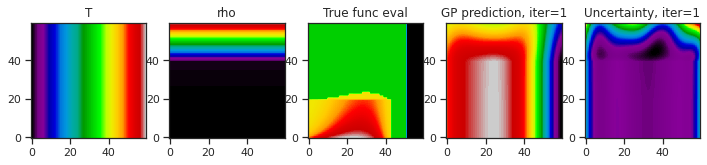

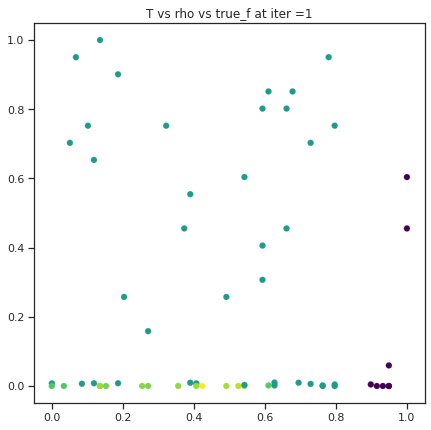

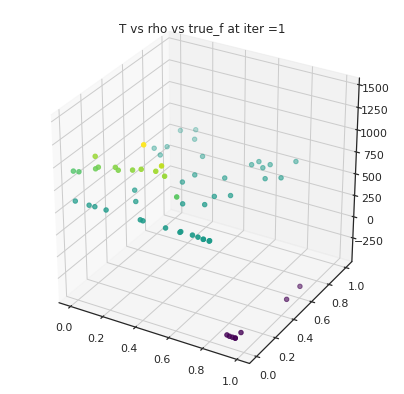

Model training:
Iteration:10
Loss:19099.472270086742
noise:1.8834264985472877
Model training:
Iteration:20
Loss:12447.384400604253
noise:2.926790081317318
Model training:
Iteration:30
Loss:9570.005631333994
noise:3.6269705951213025
Model training:
Iteration:40
Loss:8091.244613058347
noise:4.112899759766704
Model training:
Iteration:50
Loss:7341.956530772373
noise:4.489738431831845
Model training:
Iteration:60
Loss:6831.799072178735
noise:4.813999453732136
Model training:
Iteration:70
Loss:6433.151491665882
noise:5.109971967586261
Model training:
Iteration:80
Loss:6101.965777982792
noise:5.38689719488231
Model training:
Iteration:90
Loss:5819.5193020765155
noise:5.648521118933233
Model training:
Iteration:100
Loss:5573.670868073147
noise:5.8972686189932615
Model training:
Iteration:110
Loss:5355.9381440230045
noise:6.135317393432159
Model training:
Iteration:120
Loss:5161.012820750725
noise:6.36447703523406
Model training:
Iteration:130
Loss:4985.07472188076
noise:6.5860539658647115
Mod

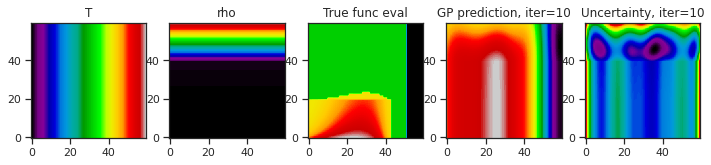

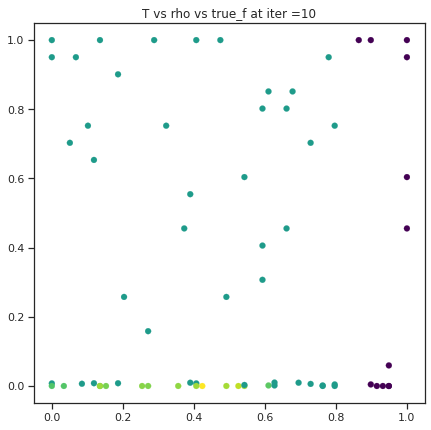

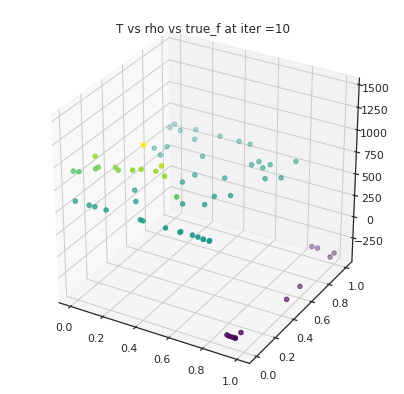

Model training:
Iteration:10
Loss:17815.63821765087
noise:1.8821509014218782
Model training:
Iteration:20
Loss:11592.592654480657
noise:2.9246506278622557
Model training:
Iteration:30
Loss:9068.336538741956
noise:3.6221046912235164
Model training:
Iteration:40
Loss:7686.875737042985
noise:4.106329308617099
Model training:
Iteration:50
Loss:6944.286913461783
noise:4.483104892153806
Model training:
Iteration:60
Loss:6454.915169426873
noise:4.807730986231987
Model training:
Iteration:70
Loss:6078.126673936528
noise:5.103650884293453
Model training:
Iteration:80
Loss:5763.967108105692
noise:5.380266474880342
Model training:
Iteration:90
Loss:5495.577605652686
noise:5.641724570847581
Model training:
Iteration:100
Loss:5261.9513916728565
noise:5.89044296762542
Model training:
Iteration:110
Loss:5055.233924853058
noise:6.128241849256489
Model training:
Iteration:120
Loss:4870.300531843081
noise:6.356639436501192
Model training:
Iteration:130
Loss:4703.482381404273
noise:6.576910829746615
Mode

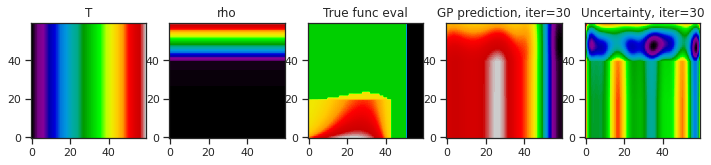

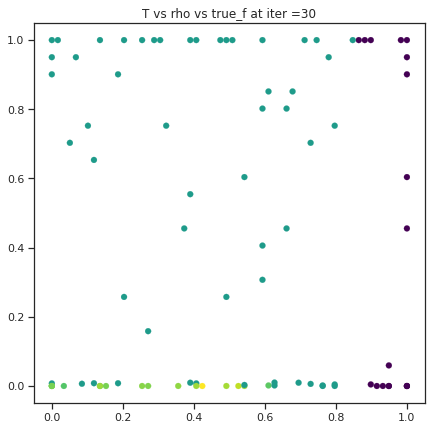

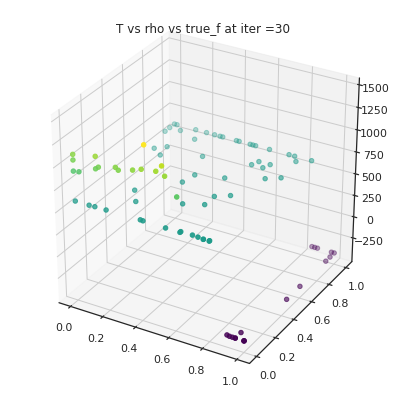

Model training:
Iteration:10
Loss:16050.819567652023
noise:1.886313047240586
Model training:
Iteration:20
Loss:10433.494329139046
noise:2.9352565150683008
Model training:
Iteration:30
Loss:8197.59890324432
noise:3.637635955739157
Model training:
Iteration:40
Loss:6919.470765066777
noise:4.124678070672474
Model training:
Iteration:50
Loss:6260.772201646328
noise:4.501637425652122
Model training:
Iteration:60
Loss:5826.56314082349
noise:4.825719344296767
Model training:
Iteration:70
Loss:5484.312377273762
noise:5.1206081997118895
Model training:
Iteration:80
Loss:5198.970347026552
noise:5.395261594070563
Model training:
Iteration:90
Loss:4956.65007355374
noise:5.653768883759798
Model training:
Iteration:100
Loss:4746.064871830969
noise:5.8989331887573755
Model training:
Iteration:110
Loss:4559.629879139767
noise:6.133133916964225
Model training:
Iteration:120
Loss:4392.740524310793
noise:6.358344829999063
Model training:
Iteration:130
Loss:4242.172682248988
noise:6.576045015087214
Model 

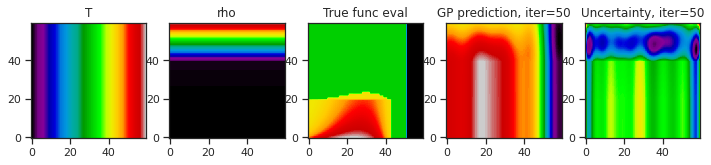

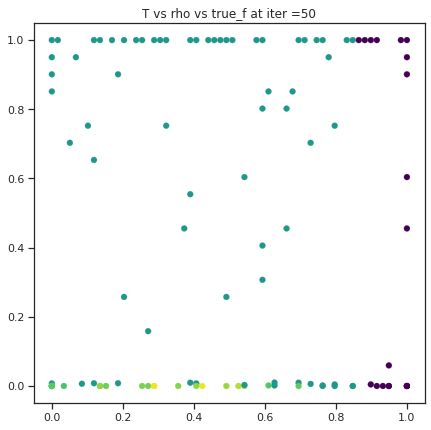

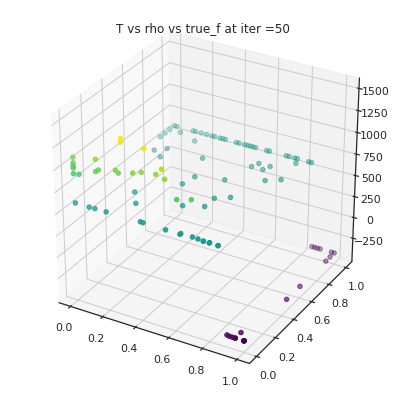

Model training:
Iteration:10
Loss:17642.32374256724
noise:1.9003426981980218
Model training:
Iteration:20
Loss:11146.539568103168
noise:2.9830515369993944
Model training:
Iteration:30
Loss:8702.124348517742
noise:3.702527467471491
Model training:
Iteration:40
Loss:7423.058035506132
noise:4.19247784304525
Model training:
Iteration:50
Loss:6741.04164959949
noise:4.568061978615818
Model training:
Iteration:60
Loss:6264.174810469245
noise:4.889924932310057
Model training:
Iteration:70
Loss:5892.807933978349
noise:5.181695043229126
Model training:
Iteration:80
Loss:5586.735749589794
noise:5.452139134279464
Model training:
Iteration:90
Loss:5327.737090300971
noise:5.7061177074502165
Model training:
Iteration:100
Loss:5101.49767891951
noise:5.947629693351363
Model training:
Iteration:110
Loss:4901.031490897815
noise:6.17972468778397
Model training:
Iteration:120
Loss:4721.81203071245
noise:6.404220112333432
Model training:
Iteration:130
Loss:4560.130554099669
noise:6.621993457039041
Model tra

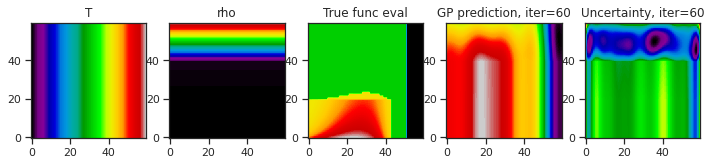

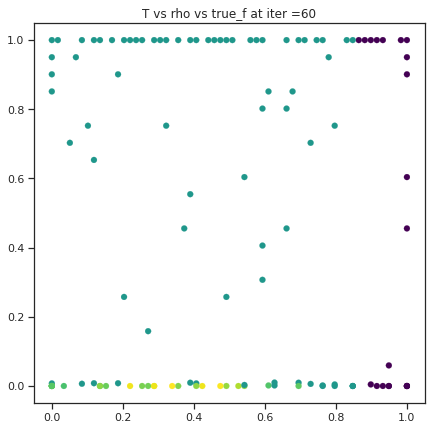

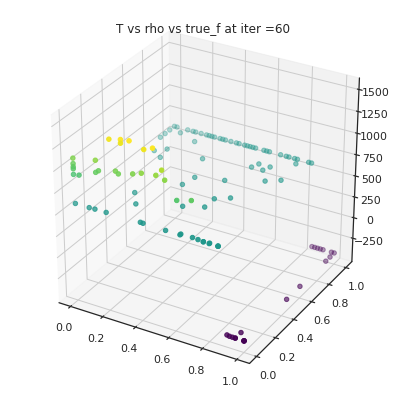

Model training:
Iteration:10
Loss:17701.468739810698
noise:1.9055044584555425
Model training:
Iteration:20
Loss:11084.941849665825
noise:3.0006157905168385
Model training:
Iteration:30
Loss:8656.473799653935
noise:3.7273769662691416
Model training:
Iteration:40
Loss:7413.668954429033
noise:4.221401588182874
Model training:
Iteration:50
Loss:6720.111691620602
noise:4.599831918865467
Model training:
Iteration:60
Loss:6248.9224321213815
noise:4.923700601605814
Model training:
Iteration:70
Loss:5877.636046417041
noise:5.217067666015373
Model training:
Iteration:80
Loss:5572.401051862485
noise:5.488928482155245
Model training:
Iteration:90
Loss:5314.35894376396
noise:5.744318567439711
Model training:
Iteration:100
Loss:5088.581114319997
noise:5.987320002566045
Model training:
Iteration:110
Loss:4888.722971756729
noise:6.2209607849013375
Model training:
Iteration:120
Loss:4710.017254444125
noise:6.4469930792118415
Model training:
Iteration:130
Loss:4548.80651323951
noise:6.666245243668662
Mo

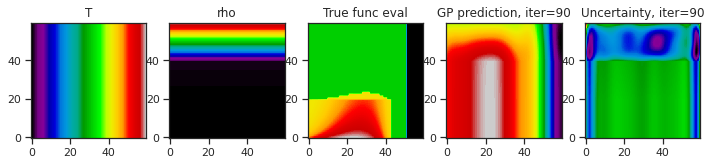

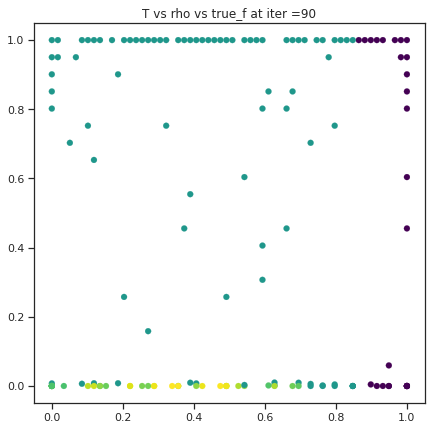

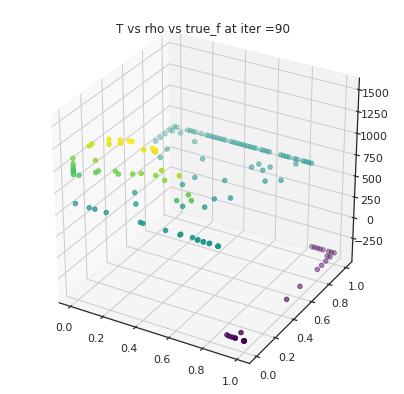

Model training:
Iteration:10
Loss:17201.125837402236
noise:1.90728139651824
Model training:
Iteration:20
Loss:10810.798670962002
noise:3.016674645189725
Model training:
Iteration:30
Loss:8544.290971925095
noise:3.765232988977229
Model training:
Iteration:40
Loss:7302.732512045329
noise:4.281773744292999
Model training:
Iteration:50
Loss:6603.76597215011
noise:4.6799614130883
Model training:
Iteration:60
Loss:6139.036368671796
noise:5.021035448162464
Model training:
Iteration:70
Loss:5777.289763424888
noise:5.331602124871847
Model training:
Iteration:80
Loss:5479.316901266238
noise:5.622197776814266
Model training:
Iteration:90
Loss:5224.277155167095
noise:5.897394271596587
Model training:
Iteration:100
Loss:5002.044637197347
noise:6.1597106626076465
Model training:
Iteration:110
Loss:4805.51405068333
noise:6.410908597688004
Model training:
Iteration:120
Loss:4629.866895534469
noise:6.6524125529939715
Model training:
Iteration:130
Loss:4471.534477989284
noise:6.885429692337861
Model tra

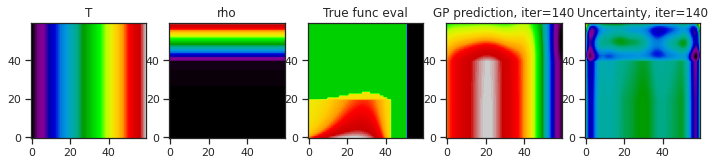

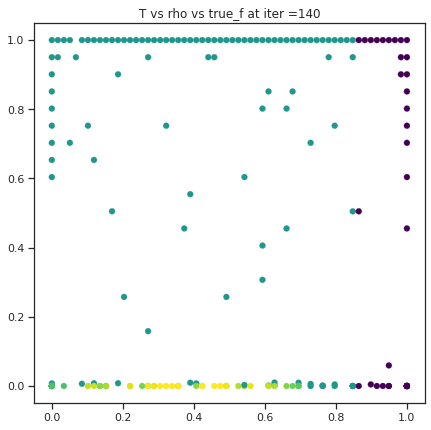

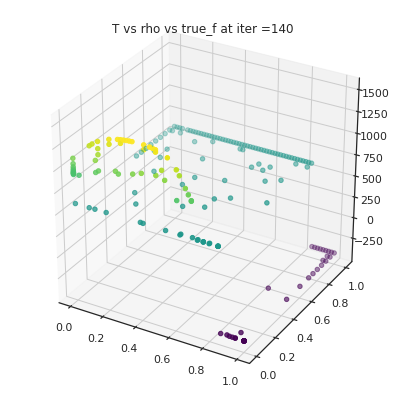

Model training:
Iteration:10
Loss:16351.087805604884
noise:1.9131970238449694
Model training:
Iteration:20
Loss:10352.175995240605
noise:3.04797932961242
Model training:
Iteration:30
Loss:8237.195369936126
noise:3.8268815983442037
Model training:
Iteration:40
Loss:7040.149152761491
noise:4.370238641731193
Model training:
Iteration:50
Loss:6346.877128125137
noise:4.78974522941019
Model training:
Iteration:60
Loss:5879.614064482373
noise:5.146994859850329
Model training:
Iteration:70
Loss:5527.508281177017
noise:5.47047875412472
Model training:
Iteration:80
Loss:5240.886257868623
noise:5.772834961277425
Model training:
Iteration:90
Loss:4997.331454551555
noise:6.059966997205423
Model training:
Iteration:100
Loss:4785.145313137681
noise:6.33474039264965
Model training:
Iteration:110
Loss:4597.508137244075
noise:6.598724554915359
Model training:
Iteration:120
Loss:4429.858940763336
noise:6.85303089194489
Model training:
Iteration:130
Loss:4278.817917211811
noise:7.098621109785551
Model tra

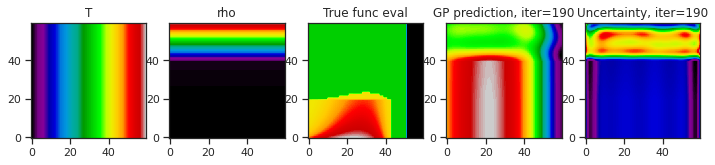

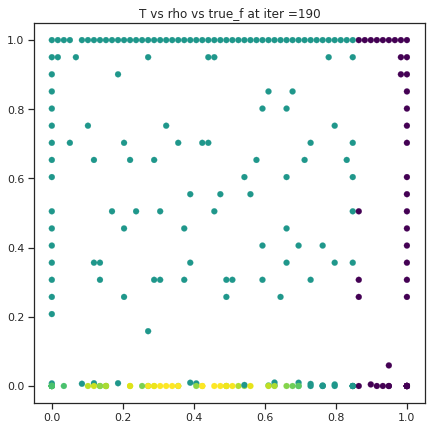

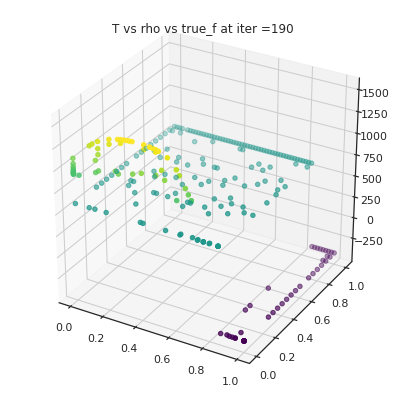

Model training:
Iteration:10
Loss:14241.168663272078
noise:1.8839970298029676
Model training:
Iteration:20
Loss:9367.790735502582
noise:2.9307545157928003
Model training:
Iteration:30
Loss:7345.733038745982
noise:3.6412693315362223
Model training:
Iteration:40
Loss:6212.448939083158
noise:4.13900571414759
Model training:
Iteration:50
Loss:5589.553194630002
noise:4.530013610603351
Model training:
Iteration:60
Loss:5191.226132293272
noise:4.868166882496365
Model training:
Iteration:70
Loss:4889.65561467412
noise:5.177603878420687
Model training:
Iteration:80
Loss:4638.706702508844
noise:5.467777198336325
Model training:
Iteration:90
Loss:4423.802823856556
noise:5.742638638487452
Model training:
Iteration:100
Loss:4236.790595756274
noise:6.004508051934611
Model training:
Iteration:110
Loss:4071.504135853949
noise:6.255164556547968
Model training:
Iteration:120
Loss:3923.6692003793564
noise:6.496210417763429
Model training:
Iteration:130
Loss:3790.3298710063336
noise:6.7289150961946085
Mod

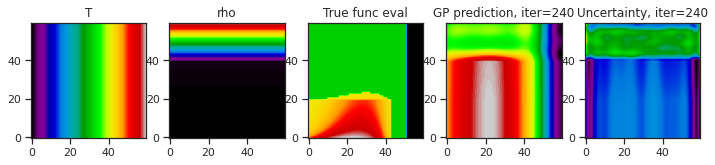

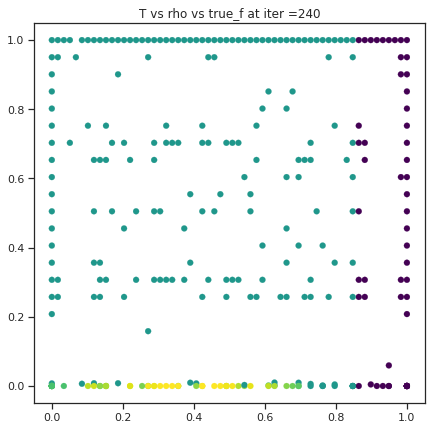

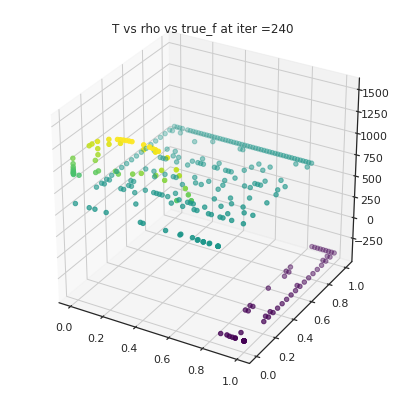

Model training:
Iteration:10
Loss:13475.87403793371
noise:1.8889513247057574
Model training:
Iteration:20
Loss:8661.80625713639
noise:2.94432114752006
Model training:
Iteration:30
Loss:6864.093850551325
noise:3.6527390092106407
Model training:
Iteration:40
Loss:5854.719269410263
noise:4.142593411865704
Model training:
Iteration:50
Loss:5277.758439404465
noise:4.523431650587037
Model training:
Iteration:60
Loss:4899.802443002784
noise:4.854082673290768
Model training:
Iteration:70
Loss:4611.56657383334
noise:5.158391551631402
Model training:
Iteration:80
Loss:4374.224181612168
noise:5.445789567220504
Model training:
Iteration:90
Loss:4171.233997351053
noise:5.719859439868771
Model training:
Iteration:100
Loss:3994.126488053222
noise:5.982139507955955
Model training:
Iteration:110
Loss:3837.45650790188
noise:6.233934257850362
Model training:
Iteration:120
Loss:3697.4180711327704
noise:6.476372021646585
Model training:
Iteration:130
Loss:3571.2044091784824
noise:6.710408330560832
Model tr

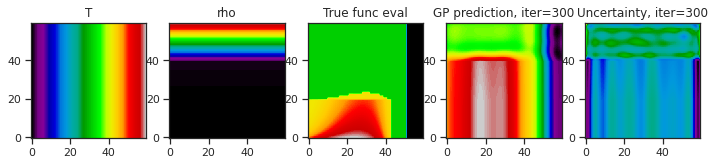

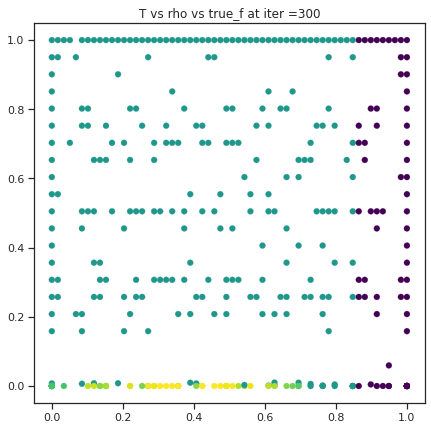

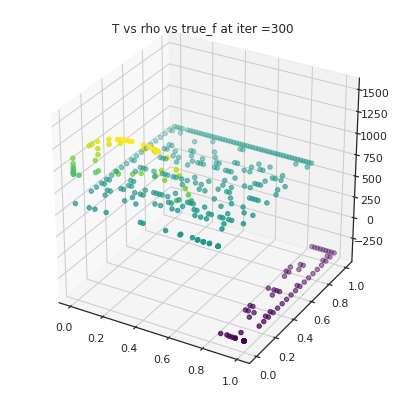

0.68244374
3.228391


In [ ]:
w = [0.2, 0.4, 0.4]
# testresult = AFIsystem(350, 10**2, 50, 0.2, w)
# print(testresult)


num_rows = 60
num_rows1 = 20
num_rows2 = 21
num_rows3 = 21
num = 60  # Starting samples
N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
N = int(N)
T = np.linspace(300, 520, num_rows)
rho1 = np.linspace(10 ** -6, 10 ** -5, num_rows1)
rho2 = np.delete(np.linspace(10 ** -5, 10 ** -3, num_rows2),0)
rho3 = np.delete(np.linspace(10 ** -3, 10 ** -1, num_rows3),0)
rho = np.hstack((rho1, rho2, rho3))
minT = min(T)
maxT = max(T)
minrho = min(rho)
maxrho = max(rho)
T, rho = np.meshgrid(T, rho)
T_norm = (T-minT)/(maxT-minT)
rho_norm = (rho-minrho)/(maxrho-minrho)
# Below variables we need as we avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
test_T = np.linspace(300, 520, num_rows)
test_rho = np.hstack((rho1, rho2, rho3))
test_T, test_rho = np.meshgrid(test_T, test_rho)
testT_norm = (test_T-minT)/(maxT-minT)
testrho_norm = (test_rho-minrho)/(maxrho-minrho)

true_Y = to.empty(num_rows, num_rows)
f = np.zeros(1)
m = 0
for t1, (x1, x2) in enumerate(zip(T, rho)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        print("Lattice site #" + str(m + 1))
        h = 50
        dG = 0.2
        feval, solAP = AFIsystem2(xx1, xx2, h, dG, w)
        f[0] = feval
        true_Y[t1, t2] = to.from_numpy(f)
        m = m + 1

# Select starting samples randomly as training data
testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
np.random.seed(10)
ind_start = np.random.choice(len(testT_norm) - 1, size=num, replace=False)
t_y = np.reshape(true_Y, (num_rows ** 2, 1))
train_X = np.zeros((num, 2))
train_Y = np.zeros(num)
for i in range(0, num):
    train_X[i, 0] = testT_norm[ind_start[i]]
    train_X[i, 1] = testrho_norm[ind_start[i]]
    train_Y[i] = t_y[ind_start[i]]
    testT_norm[ind_start[i]] =-1
    testrho_norm[ind_start[i]] =-1

testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))

train_X = to.from_numpy(train_X)
train_X = train_X.double()
# train_X = train_X.unsqueeze(1)
train_Y = to.from_numpy(train_Y)
train_y = to.empty(train_Y.__len__(), 1)
train_y[:, 0] = train_Y

# Gp model fit
gp_PZO = SimpleCustomGP(train_X, train_y)
gp_PZO = gp_PZO.double()
gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
# fit_gpytorch_model(mll)
mll = mll.to(train_X)
gp_PZO.train()
gp_PZO.likelihood.train()

from torch.optim import SGD
from torch.optim import Adam
optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

NUM_EPOCHS = 150

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = gp_PZO(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, gp_PZO.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print("Model training:")
        print("Iteration:" + str(epoch + 1))
        print("Loss:" + str(loss.item()))
        # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
        print("noise:" + str(gp_PZO.likelihood.noise.item()))

    optimizer.step()

gp_PZO.eval()
gp_PZO.likelihood.eval()

for i in range(1, N + 1):
    ## Evaluating the posterior means and variances of the non-sampled lattice sites
    y_pred_means = to.empty(num_rows, num_rows)
    y_pred_vars = to.empty(num_rows, num_rows)
    for t1, (x1, x2) in enumerate(zip(testT_norm, testrho_norm)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2] = 0
                y_pred_vars[t1, t2] = 1e-6
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means[t1, t2] = y_pred_PZO.mean
                    y_pred_vars[t1, t2] = y_pred_PZO.variance

    if (i == 1 or i == 10 or i == 30 or i == 50 or i == 60 or i == 90 or i == 140 or i == 190 or i == 240):
        y_pred_means_full = to.empty(num_rows, num_rows)
        y_pred_vars_full = to.empty(num_rows, num_rows)
        for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
            for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means_full[t1, t2] = y_pred_PZO.mean
                    y_pred_vars_full[t1, t2] = y_pred_PZO.variance

        t_x = train_X
        t_x = t_x.detach().numpy()
        t_x = np.reshape(t_x, (train_X.__len__(), 2))
        t_y = train_y
        t_y = t_y.detach().numpy()
        t_y = np.reshape(t_y, (train_X.__len__(), 1))
        # plot_exploration_results3D(test_T, test_rho, true_Y, y_pred_means, y_pred_vars, t_x, t_y, i)
        plot_exploration_results3D(T, rho, true_Y, y_pred_means_full, y_pred_vars_full, t_x, t_y, i)

    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    y_v = np.reshape(y_pred_vars, (num_rows ** 2, 1))
    acq_val = np.max(y_pred_vars)
    val = acq_val
    acq_cand = [k for k, j in enumerate(y_v) if j == acq_val]
    ind = np.random.choice(acq_cand)

    ## Find next point which maximizes the learning through exploration
    if (i == 1):
        val_ini = val
    # Check for convergence
    if ((val) <= 1e-5):  # Stop for negligible expected improvement
        print("Model converged due to sufficient reduction of uncertainty over search space ")
        break
    else:
        # Find the true P values of next X, augment to the training dataset
        nextX = to.empty(1, 2)
        next_feval = to.empty(1, 1)
        testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
        testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
        t_y = np.reshape(true_Y, (num_rows ** 2, 1))
        nextX[0, 0] = to.from_numpy(testT_norm[ind])
        nextX[0, 1] = to.from_numpy(testrho_norm[ind])
        testT_norm[ind] = -1
        testrho_norm[ind] = -1
        testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
        testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))
        next_feval[:, 0] = t_y[ind]
        train_X = to.cat((train_X, nextX), 0)
        train_X = train_X.double()
        train_y = to.cat((train_y, next_feval), 0)

        # Updating GP model, conditioning on new data
        # Gp model fit
        gp_PZO = SimpleCustomGP(train_X, train_y)
        gp_PZO = gp_PZO.double()
        gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
        mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
        # fit_gpytorch_model(mll)
        mll = mll.to(train_X)
        gp_PZO.train()
        gp_PZO.likelihood.train()

        optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

        NUM_EPOCHS = 150

        for epoch in range(NUM_EPOCHS):
            # clear gradients
            optimizer.zero_grad()
            # forward pass through the model to obtain the output MultivariateNormal
            output = gp_PZO(train_X)
            # Compute negative marginal log likelihood
            loss = - mll(output, gp_PZO.train_targets)
            # back prop gradients
            loss.backward()
            # print every 10 iterations
            if (epoch + 1) % 10 == 0:
                print("Model training:")
                print("Iteration:" + str(epoch + 1))
                print("Loss:" + str(loss.item()))
                # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
                print("noise:" + str(gp_PZO.likelihood.noise.item()))

            optimizer.step()

        gp_PZO.eval()
        gp_PZO.likelihood.eval()

y_pred_means_full = to.empty(num_rows, num_rows)
y_pred_vars_full = to.empty(num_rows, num_rows)
for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        test_X = to.empty(1, 2)
        test_X[:, 0] = xx1
        test_X[:, 1] = xx2
        test_X = test_X.double()
        with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
             gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
             gpt.settings.max_cg_iterations(100), \
             gpt.settings.max_preconditioner_size(80), \
             gpt.settings.num_trace_samples(128):
            y_pred_PZO = gp_PZO.posterior(test_X)
            # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
            y_pred_means_full[t1, t2] = y_pred_PZO.mean
            y_pred_vars_full[t1, t2] = y_pred_PZO.variance

P_pred_conv = (y_pred_means_full)
#P_var_cov = to.from_numpy(y_pred_vars)
P_var_cov = (y_pred_vars_full)
# Plots
t_x = train_X
t_x = t_x.detach().numpy()
t_x = np.reshape(t_x, (train_X.__len__(), 2))
t_y = train_y
t_y = t_y.detach().numpy()
t_y = np.reshape(t_y, (train_X.__len__(), 1))
plot_exploration_results3D(T, rho, true_Y, P_pred_conv, P_var_cov, t_x, t_y, i)
if (i == N + 1):
    print("Max. sampling reached, model stopped")
print(val)
print(val_ini)

<h1> Observation

Total grid points is 3600, and we stop our GP exploration after using 360 sample points (10% utilization). The GP prediction is done based on 360 adaptively selected (full exploration) samples.

In the true image (middle figure),
Black region is the PE phase, green region is the AFE phase and yellow/red/white region is the FEI phase. In the FEI phase, yellow region is the area having deeper wells at A and as the objective value increases (with color changing from yellow to red to white), we have deeper wells at P. The domain does not have AFI phase

In the GP predicted image (4th figure), we can see similar distinctive region with different color coding and thus gave us the interpretation of individual phases. We can have better prediction of phases with more advanced aquistion function (exploration -exploitation) to sample where the objective function is higher.

<h1> Analysis 3

$E=0, \gamma_{a,p}=0, h=50 nm, dG_1 = dG_2 = 0.02 eV$

Parameter space over $T$ and $\rho$

$T=[300, 520], \rho =[10^{1}, 10^{6}]$

Lattice site #1
Lattice site #2
Lattice site #3
Lattice site #4
Lattice site #5
Lattice site #6
Lattice site #7
Lattice site #8
Lattice site #9
Lattice site #10
Lattice site #11
Lattice site #12
Lattice site #13
Lattice site #14
Lattice site #15
Lattice site #16
Lattice site #17
Lattice site #18
Lattice site #19
Lattice site #20
Lattice site #21
Lattice site #22
Lattice site #23
Lattice site #24
Lattice site #25
Lattice site #26
Lattice site #27
Lattice site #28
Lattice site #29
Lattice site #30
Lattice site #31
Lattice site #32
Lattice site #33
Lattice site #34
Lattice site #35
Lattice site #36
Lattice site #37
Lattice site #38
Lattice site #39
Lattice site #40
Lattice site #41
Lattice site #42
Lattice site #43
Lattice site #44
Lattice site #45
Lattice site #46
Lattice site #47
Lattice site #48
Lattice site #49
Lattice site #50
Lattice site #51
Lattice site #52
Lattice site #53
Lattice site #54
Lattice site #55
Lattice site #56
Lattice site #57
Lattice site #58
Lattice site #59
Lattic

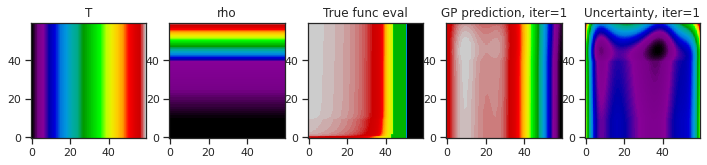

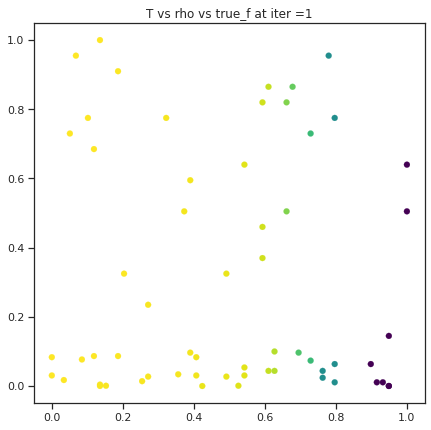

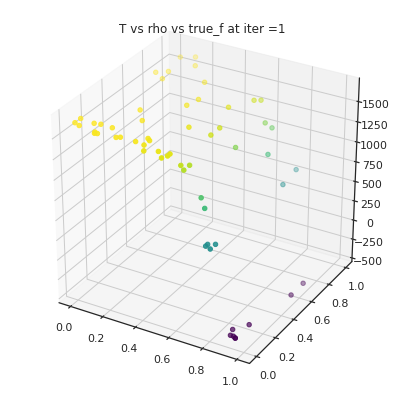

Model training:
Iteration:10
Loss:24539.469958092104
noise:1.7504600570719768
Model training:
Iteration:20
Loss:16017.776434715537
noise:2.4147093877376395
Model training:
Iteration:30
Loss:11442.104267087236
noise:2.7826967730801426
Model training:
Iteration:40
Loss:10083.530021381424
noise:3.019702844739403
Model training:
Iteration:50
Loss:9106.285645547632
noise:3.2101866365314975
Model training:
Iteration:60
Loss:8465.598177227239
noise:3.3696746866082488
Model training:
Iteration:70
Loss:7988.323478525422
noise:3.5066141464787095
Model training:
Iteration:80
Loss:7583.9930833127
noise:3.632949099843877
Model training:
Iteration:90
Loss:7243.404840896763
noise:3.7559621669416487
Model training:
Iteration:100
Loss:6942.747849251956
noise:3.877047912205878
Model training:
Iteration:110
Loss:6676.209188385302
noise:3.995413478265121
Model training:
Iteration:120
Loss:6436.6512490837285
noise:4.111121049659414
Model training:
Iteration:130
Loss:6219.939241550955
noise:4.22475021187173

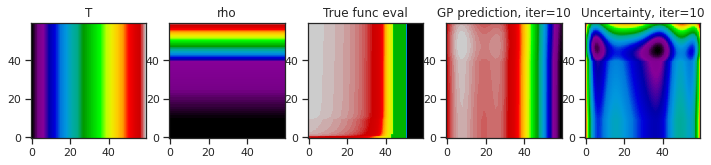

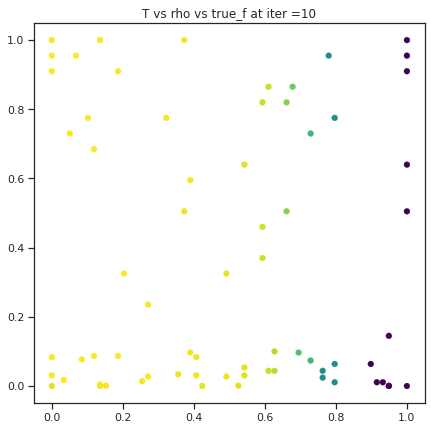

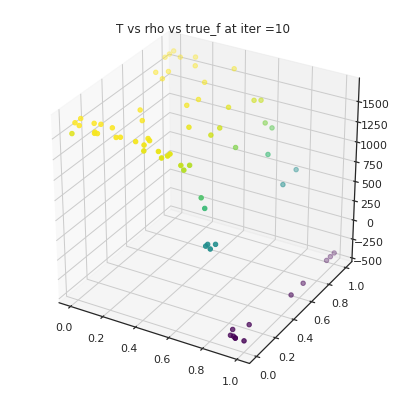

Model training:
Iteration:10
Loss:22647.92063123078
noise:1.7526881580548375
Model training:
Iteration:20
Loss:14869.530871587078
noise:2.4346162779786353
Model training:
Iteration:30
Loss:10622.407139034827
noise:2.8302455659241854
Model training:
Iteration:40
Loss:9342.827036524399
noise:3.094220929816607
Model training:
Iteration:50
Loss:8466.736729443783
noise:3.309365039471693
Model training:
Iteration:60
Loss:7864.976828622419
noise:3.4948175876804686
Model training:
Iteration:70
Loss:7427.540735780344
noise:3.6583789435548697
Model training:
Iteration:80
Loss:7052.608431814499
noise:3.8105309904515803
Model training:
Iteration:90
Loss:6736.807022860094
noise:3.9580335575580596
Model training:
Iteration:100
Loss:6458.0165909550315
noise:4.10274068123763
Model training:
Iteration:110
Loss:6210.398750049986
noise:4.244133562917912
Model training:
Iteration:120
Loss:5987.89945644777
noise:4.3820982178789505
Model training:
Iteration:130
Loss:5786.479539043545
noise:4.517093431588526

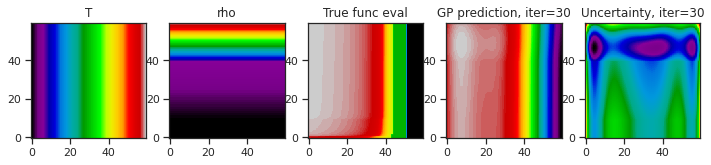

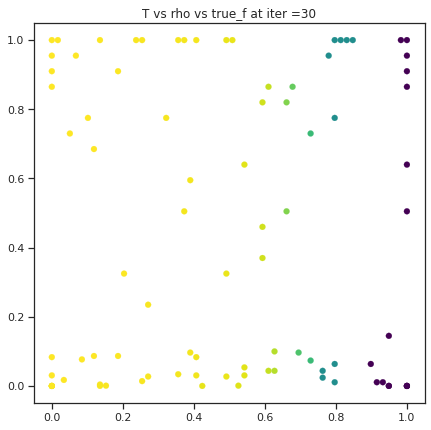

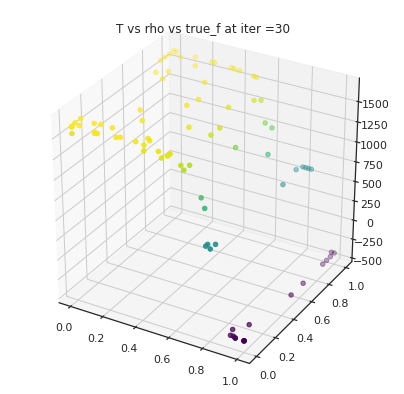

Model training:
Iteration:10
Loss:18351.047711650517
noise:1.7550645099125766
Model training:
Iteration:20
Loss:12265.519410369261
noise:2.4464744017855082
Model training:
Iteration:30
Loss:8772.866101319389
noise:2.852592813917589
Model training:
Iteration:40
Loss:7591.215529189123
noise:3.1264422365763442
Model training:
Iteration:50
Loss:6940.923745512941
noise:3.3508207508605774
Model training:
Iteration:60
Loss:6429.850848552738
noise:3.550469912553242
Model training:
Iteration:70
Loss:6074.423027717653
noise:3.7298087327259983
Model training:
Iteration:80
Loss:5770.393124683027
noise:3.8963077954009746
Model training:
Iteration:90
Loss:5510.785239286129
noise:4.056436465482912
Model training:
Iteration:100
Loss:5283.604631253
noise:4.2130793439080705
Model training:
Iteration:110
Loss:5080.865057487273
noise:4.366320219464314
Model training:
Iteration:120
Loss:4898.902986742555
noise:4.515746819174807
Model training:
Iteration:130
Loss:4734.099700663722
noise:4.661515260280988
Mo

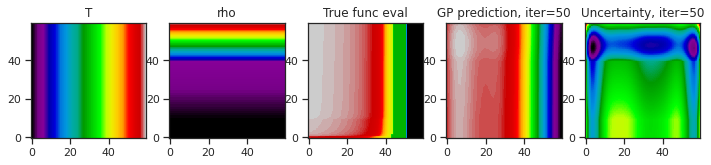

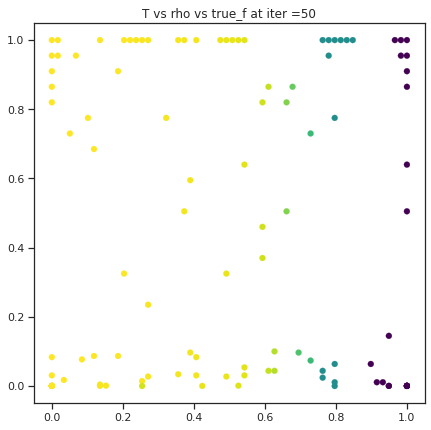

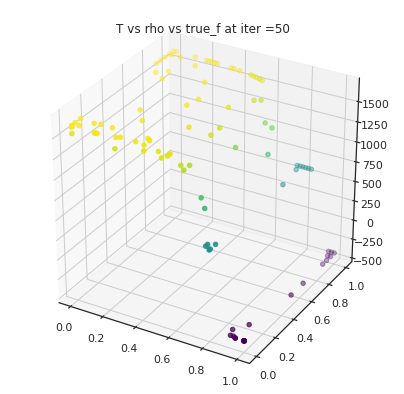

Model training:
Iteration:10
Loss:15467.995582726999
noise:1.7573255806010732
Model training:
Iteration:20
Loss:10496.011615869404
noise:2.454643143368871
Model training:
Iteration:30
Loss:7516.999506021033
noise:2.8680773723190933
Model training:
Iteration:40
Loss:6405.68158048832
noise:3.1481604626181654
Model training:
Iteration:50
Loss:5887.899039323468
noise:3.3763346869051567
Model training:
Iteration:60
Loss:5451.969087126227
noise:3.5817669321814374
Model training:
Iteration:70
Loss:5146.966791744062
noise:3.768770000639376
Model training:
Iteration:80
Loss:4892.640265308402
noise:3.94272243134013
Model training:
Iteration:90
Loss:4671.908513498281
noise:4.109310603246785
Model training:
Iteration:100
Loss:4479.661213233617
noise:4.2717048800972455
Model training:
Iteration:110
Loss:4307.925318129288
noise:4.4305453155378505
Model training:
Iteration:120
Loss:4153.610989324195
noise:4.585509582893547
Model training:
Iteration:130
Loss:4013.8784126538044
noise:4.736563309396964


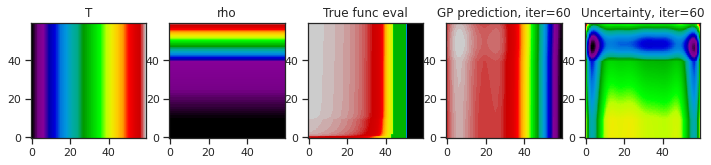

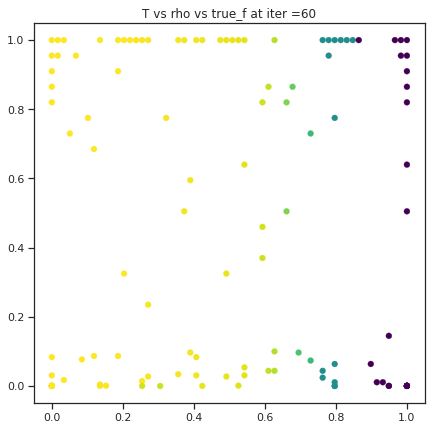

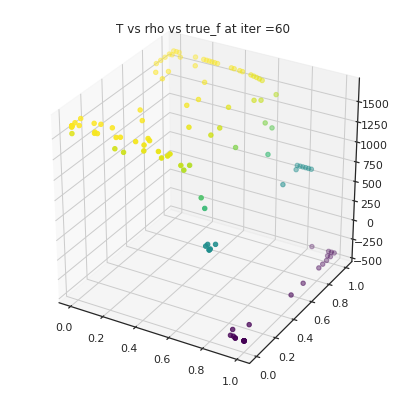

Model training:
Iteration:10
Loss:15073.559227400983
noise:1.7800807695669552
Model training:
Iteration:20
Loss:10291.87474059536
noise:2.5300887677871637
Model training:
Iteration:30
Loss:7412.096521447807
noise:2.9891949457064104
Model training:
Iteration:40
Loss:6285.44206795735
noise:3.307257117478143
Model training:
Iteration:50
Loss:5782.3686906538915
noise:3.567484636050286
Model training:
Iteration:60
Loss:5354.981361469608
noise:3.801332827204985
Model training:
Iteration:70
Loss:5052.928703761336
noise:4.014423974662929
Model training:
Iteration:80
Loss:4802.896189955316
noise:4.2122825370508234
Model training:
Iteration:90
Loss:4585.344930927486
noise:4.400798949953634
Model training:
Iteration:100
Loss:4395.957826375213
noise:4.583464637063051
Model training:
Iteration:110
Loss:4226.888827459761
noise:4.761245205227959
Model training:
Iteration:120
Loss:4074.980860838319
noise:4.934045376719939
Model training:
Iteration:130
Loss:3937.4850088137873
noise:5.101960997392756
Mo

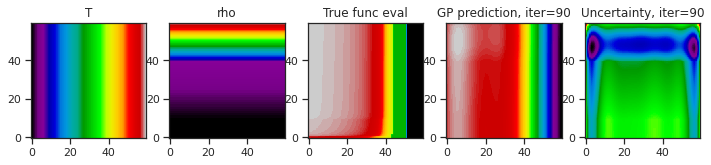

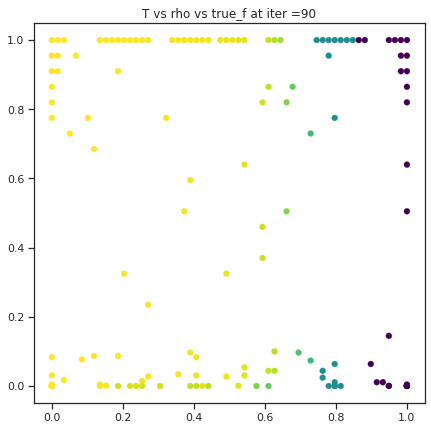

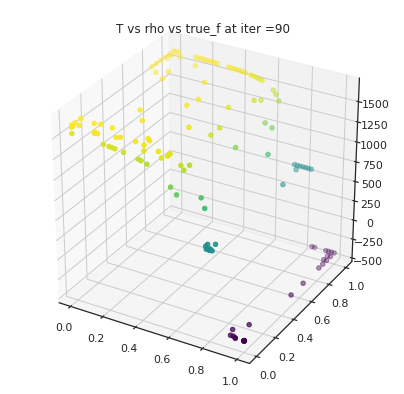

Model training:
Iteration:10
Loss:13049.17347638154
noise:1.797487673858428
Model training:
Iteration:20
Loss:9049.303097695838
noise:2.6017957164587755
Model training:
Iteration:30
Loss:6637.059393803542
noise:3.1139502430238633
Model training:
Iteration:40
Loss:5524.913436882554
noise:3.4775685985547513
Model training:
Iteration:50
Loss:5077.198226416661
noise:3.775182363840731
Model training:
Iteration:60
Loss:4718.395308761604
noise:4.042430648277037
Model training:
Iteration:70
Loss:4441.343805352387
noise:4.288344530090557
Model training:
Iteration:80
Loss:4222.553318342993
noise:4.517042304834101
Model training:
Iteration:90
Loss:4031.069960431232
noise:4.733353511470557
Model training:
Iteration:100
Loss:3863.650781958492
noise:4.940975681266379
Model training:
Iteration:110
Loss:3714.9906068182277
noise:5.141759725979132
Model training:
Iteration:120
Loss:3581.2854454889257
noise:5.336287683399925
Model training:
Iteration:130
Loss:3460.3553300029344
noise:5.5248338310159415
M

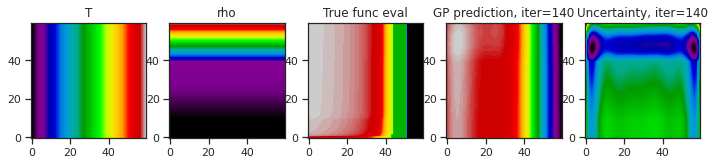

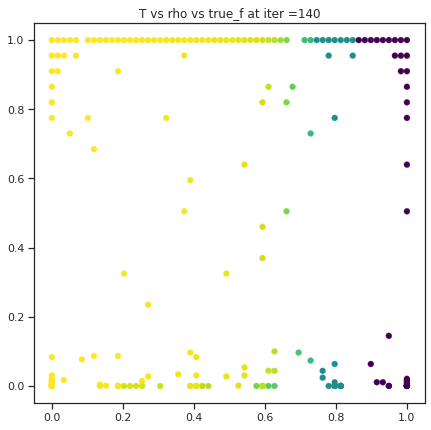

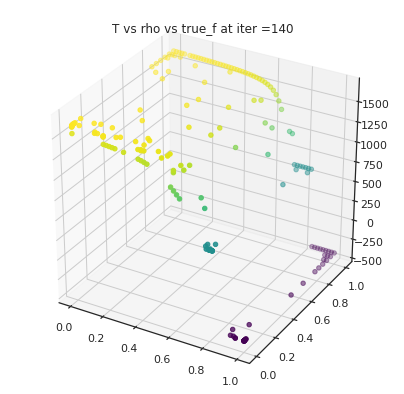

Model training:
Iteration:10
Loss:10764.875965169247
noise:1.8016887042075744
Model training:
Iteration:20
Loss:7588.85723869979
noise:2.6232232854079864
Model training:
Iteration:30
Loss:5679.577792525665
noise:3.15101504014966
Model training:
Iteration:40
Loss:4670.967662722031
noise:3.5267812844253736
Model training:
Iteration:50
Loss:4226.150759400508
noise:3.8347909630995645
Model training:
Iteration:60
Loss:3955.4982665745697
noise:4.111840019848597
Model training:
Iteration:70
Loss:3720.9029292175674
noise:4.369932002279351
Model training:
Iteration:80
Loss:3534.574405432563
noise:4.61210740080272
Model training:
Iteration:90
Loss:3376.3498733867727
noise:4.840997272059319
Model training:
Iteration:100
Loss:3236.301882295488
noise:5.059487575698144
Model training:
Iteration:110
Loss:3111.987284664567
noise:5.269760612673157
Model training:
Iteration:120
Loss:3000.4149772137707
noise:5.473035439668144
Model training:
Iteration:130
Loss:2899.3905874079237
noise:5.669917031992253
M

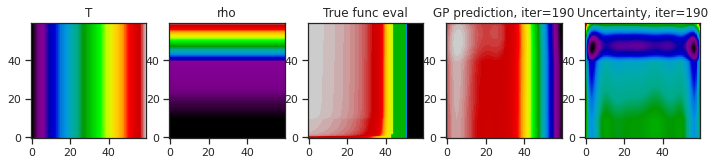

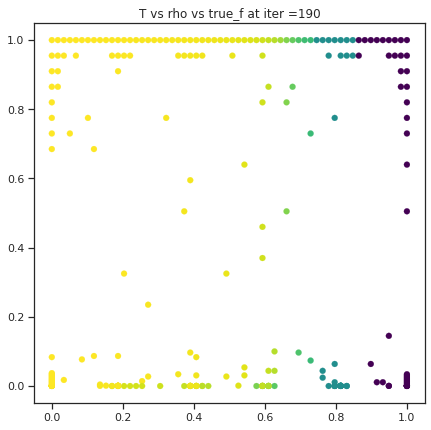

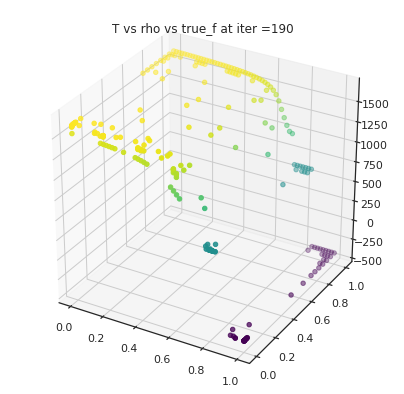

Model training:
Iteration:10
Loss:9365.637635597832
noise:1.8076808684104018
Model training:
Iteration:20
Loss:6636.088261180868
noise:2.6538247174829714
Model training:
Iteration:30
Loss:5043.067689754601
noise:3.2044434095954104
Model training:
Iteration:40
Loss:4142.911454592613
noise:3.5976674157284836
Model training:
Iteration:50
Loss:3705.884301362725
noise:3.9191030591484037
Model training:
Iteration:60
Loss:3464.4132462577736
noise:4.2075287264798025
Model training:
Iteration:70
Loss:3266.6813022840074
noise:4.476604813586814
Model training:
Iteration:80
Loss:3099.9358057074764
noise:4.730214510439265
Model training:
Iteration:90
Loss:2960.660837758449
noise:4.970226716400634
Model training:
Iteration:100
Loss:2838.3316192663356
noise:5.198803751967
Model training:
Iteration:110
Loss:2729.2631441398726
noise:5.4180213696741335
Model training:
Iteration:120
Loss:2631.467595412702
noise:5.629391549540238
Model training:
Iteration:130
Loss:2543.0137463632377
noise:5.83384874812812

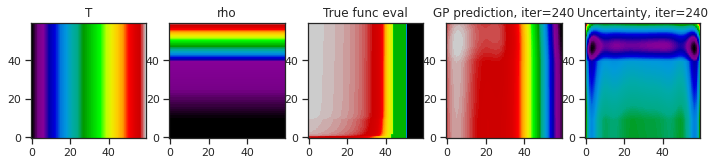

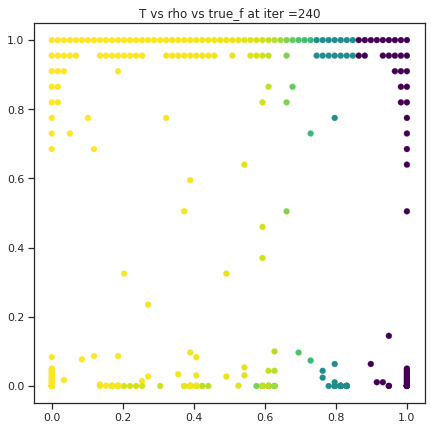

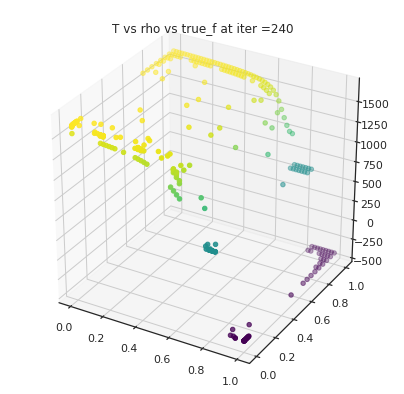

Model training:
Iteration:10
Loss:8299.642420889973
noise:1.8086345389564604
Model training:
Iteration:20
Loss:5923.85274762942
noise:2.6640922334260884
Model training:
Iteration:30
Loss:4566.239515132229
noise:3.223353994738886
Model training:
Iteration:40
Loss:3751.418717262359
noise:3.6226363012905485
Model training:
Iteration:50
Loss:3329.5250692082727
noise:3.948450243810592
Model training:
Iteration:60
Loss:3096.1858169406546
noise:4.240948220364021
Model training:
Iteration:70
Loss:2925.117075382194
noise:4.5146876022083005
Model training:
Iteration:80
Loss:2776.3735648012994
noise:4.7738430494367945
Model training:
Iteration:90
Loss:2650.3726656473796
noise:5.019775246057267
Model training:
Iteration:100
Loss:2541.0426839398474
noise:5.253924359231662
Model training:
Iteration:110
Loss:2443.6418471194247
noise:5.478031488519875
Model training:
Iteration:120
Loss:2356.1565564175016
noise:5.693663648664969
Model training:
Iteration:130
Loss:2277.0798329290333
noise:5.901965367216

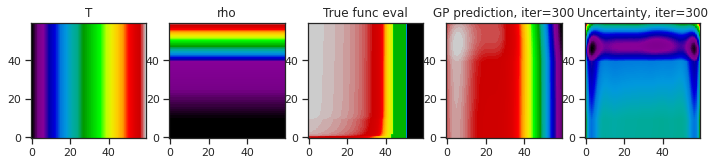

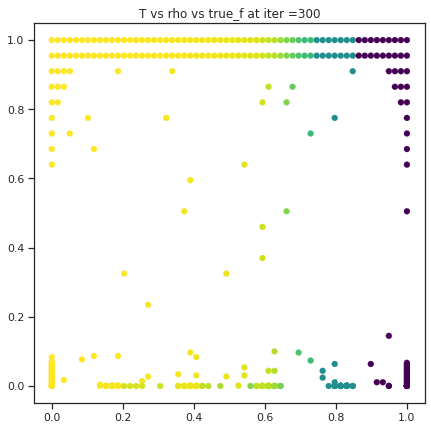

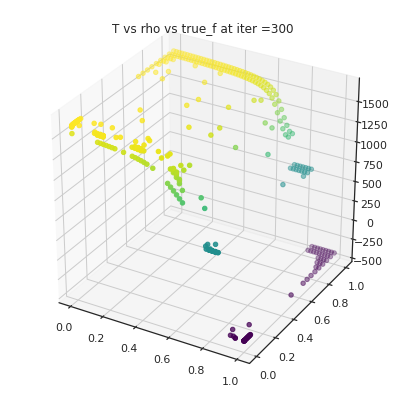

0.1438629
1.0808573


In [ ]:
w = [0.2, 0.4, 0.4]
# testresult = AFIsystem(350, 10**2, 50, 0.2, w)
# print(testresult)


num_rows = 60
num_rows1 = 10
num_rows2 = 31
num_rows3 = 21
num = 60  # Starting samples
N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
N = int(N)
T = np.linspace(300, 520, num_rows)
rho1 = np.linspace(10 ** 1, 10 ** 3, num_rows1)
rho2 = np.delete(np.linspace(10 ** 3, 10 ** 5, num_rows2),0)
rho3 = np.delete(np.linspace(10 ** 5, 10 ** 6, num_rows3),0)
rho = np.hstack((rho1, rho2, rho3))
minT = min(T)
maxT = max(T)
minrho = min(rho)
maxrho = max(rho)
T, rho = np.meshgrid(T, rho)
T_norm = (T-minT)/(maxT-minT)
rho_norm = (rho-minrho)/(maxrho-minrho)
# Below variables we need as we avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
test_T = np.linspace(300, 520, num_rows)
test_rho = np.hstack((rho1, rho2, rho3))
test_T, test_rho = np.meshgrid(test_T, test_rho)
testT_norm = (test_T-minT)/(maxT-minT)
testrho_norm = (test_rho-minrho)/(maxrho-minrho)

true_Y = to.empty(num_rows, num_rows)
f = np.zeros(1)
m = 0
for t1, (x1, x2) in enumerate(zip(T, rho)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        print("Lattice site #" + str(m + 1))
        #print(xx1)
        #print(xx2)
        h = 50
        dG = 0.02
        feval, solAP = AFIsystem2(xx1, xx2, h, dG, w)
        f[0] = feval
        true_Y[t1, t2] = to.from_numpy(f)
        m = m + 1

# Select starting samples randomly as training data
testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
np.random.seed(10)
ind_start = np.random.choice(len(testT_norm) - 1, size=num, replace=False)
t_y = np.reshape(true_Y, (num_rows ** 2, 1))
train_X = np.zeros((num, 2))
train_Y = np.zeros(num)
for i in range(0, num):
    train_X[i, 0] = testT_norm[ind_start[i]]
    train_X[i, 1] = testrho_norm[ind_start[i]]
    train_Y[i] = t_y[ind_start[i]]
    testT_norm[ind_start[i]] =-1
    testrho_norm[ind_start[i]] =-1

testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))

train_X = to.from_numpy(train_X)
train_X = train_X.double()
# train_X = train_X.unsqueeze(1)
train_Y = to.from_numpy(train_Y)
train_y = to.empty(train_Y.__len__(), 1)
train_y[:, 0] = train_Y

# Gp model fit
gp_PZO = SimpleCustomGP(train_X, train_y)
gp_PZO = gp_PZO.double()
gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
# fit_gpytorch_model(mll)
mll = mll.to(train_X)
gp_PZO.train()
gp_PZO.likelihood.train()

from torch.optim import SGD
from torch.optim import Adam
optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

NUM_EPOCHS = 150

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = gp_PZO(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, gp_PZO.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print("Model training:")
        print("Iteration:" + str(epoch + 1))
        print("Loss:" + str(loss.item()))
        # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
        print("noise:" + str(gp_PZO.likelihood.noise.item()))

    optimizer.step()

gp_PZO.eval()
gp_PZO.likelihood.eval()

for i in range(1, N + 1):
    ## Evaluating the posterior means and variances of the non-sampled lattice sites
    y_pred_means = to.empty(num_rows, num_rows)
    y_pred_vars = to.empty(num_rows, num_rows)
    for t1, (x1, x2) in enumerate(zip(testT_norm, testrho_norm)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2] = 0
                y_pred_vars[t1, t2] = 1e-6
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means[t1, t2] = y_pred_PZO.mean
                    y_pred_vars[t1, t2] = y_pred_PZO.variance

    if (i == 1 or i == 10 or i == 30 or i == 50 or i == 60 or i == 90 or i == 140 or i == 190 or i == 240):
        y_pred_means_full = to.empty(num_rows, num_rows)
        y_pred_vars_full = to.empty(num_rows, num_rows)
        for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
            for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means_full[t1, t2] = y_pred_PZO.mean
                    y_pred_vars_full[t1, t2] = y_pred_PZO.variance

        t_x = train_X
        t_x = t_x.detach().numpy()
        t_x = np.reshape(t_x, (train_X.__len__(), 2))
        t_y = train_y
        t_y = t_y.detach().numpy()
        t_y = np.reshape(t_y, (train_X.__len__(), 1))
        # plot_exploration_results3D(test_T, test_rho, true_Y, y_pred_means, y_pred_vars, t_x, t_y, i)
        plot_exploration_results3D(T, rho, true_Y, y_pred_means_full, y_pred_vars_full, t_x, t_y, i)

    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    y_v = np.reshape(y_pred_vars, (num_rows ** 2, 1))
    acq_val = np.max(y_pred_vars)
    val = acq_val
    acq_cand = [k for k, j in enumerate(y_v) if j == acq_val]
    ind = np.random.choice(acq_cand)

    ## Find next point which maximizes the learning through exploration
    if (i == 1):
        val_ini = val
    # Check for convergence
    if ((val) <= 1e-5):  # Stop for negligible expected improvement
        print("Model converged due to sufficient reduction of uncertainty over search space ")
        break
    else:
        # Find the true P values of next X, augment to the training dataset
        nextX = to.empty(1, 2)
        next_feval = to.empty(1, 1)
        testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
        testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
        t_y = np.reshape(true_Y, (num_rows ** 2, 1))
        nextX[0, 0] = to.from_numpy(testT_norm[ind])
        nextX[0, 1] = to.from_numpy(testrho_norm[ind])
        testT_norm[ind] = -1
        testrho_norm[ind] = -1
        testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
        testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))
        next_feval[:, 0] = t_y[ind]
        train_X = to.cat((train_X, nextX), 0)
        train_X = train_X.double()
        train_y = to.cat((train_y, next_feval), 0)

        # Updating GP model, conditioning on new data
        # Gp model fit
        gp_PZO = SimpleCustomGP(train_X, train_y)
        gp_PZO = gp_PZO.double()
        gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
        mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
        # fit_gpytorch_model(mll)
        mll = mll.to(train_X)
        gp_PZO.train()
        gp_PZO.likelihood.train()

        optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

        NUM_EPOCHS = 150

        for epoch in range(NUM_EPOCHS):
            # clear gradients
            optimizer.zero_grad()
            # forward pass through the model to obtain the output MultivariateNormal
            output = gp_PZO(train_X)
            # Compute negative marginal log likelihood
            loss = - mll(output, gp_PZO.train_targets)
            # back prop gradients
            loss.backward()
            # print every 10 iterations
            if (epoch + 1) % 10 == 0:
                print("Model training:")
                print("Iteration:" + str(epoch + 1))
                print("Loss:" + str(loss.item()))
                # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
                print("noise:" + str(gp_PZO.likelihood.noise.item()))

            optimizer.step()

        gp_PZO.eval()
        gp_PZO.likelihood.eval()

y_pred_means_full = to.empty(num_rows, num_rows)
y_pred_vars_full = to.empty(num_rows, num_rows)
for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        test_X = to.empty(1, 2)
        test_X[:, 0] = xx1
        test_X[:, 1] = xx2
        test_X = test_X.double()
        with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
             gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
             gpt.settings.max_cg_iterations(100), \
             gpt.settings.max_preconditioner_size(80), \
             gpt.settings.num_trace_samples(128):
            y_pred_PZO = gp_PZO.posterior(test_X)
            # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
            y_pred_means_full[t1, t2] = y_pred_PZO.mean
            y_pred_vars_full[t1, t2] = y_pred_PZO.variance

P_pred_conv = (y_pred_means_full)
#P_var_cov = to.from_numpy(y_pred_vars)
P_var_cov = (y_pred_vars_full)
# Plots
t_x = train_X
t_x = t_x.detach().numpy()
t_x = np.reshape(t_x, (train_X.__len__(), 2))
t_y = train_y
t_y = t_y.detach().numpy()
t_y = np.reshape(t_y, (train_X.__len__(), 1))
plot_exploration_results3D(T, rho, true_Y, P_pred_conv, P_var_cov, t_x, t_y, i)
if (i == N + 1):
    print("Max. sampling reached, model stopped")
print(val)
print(val_ini)

<h1> Observation

Total grid points is 3600, and we stop our GP exploration after using 360 sample points (10% utilization). The GP prediction is done based on 360 adaptively selected (full exploration) samples.

In the true image (middle figure),
Black region is the PE phase, green region is the AFE phase and yellow/red/white region is the FEI phase. In the FEI phase, yellow region is the area having deeper wells at A and as the objective value increases (with color changing from yellow to red to white), we have deeper wells at P. The domain does not have AFI phase

In the GP predicted image (4th figure), we can see similar distinctive region with different color coding and thus gave us the interpretation of individual phases. We can have better prediction of phases with more advanced aquistion function (exploration -exploitation) to sample where the objective function is higher.

**We see as $dG$ decreases, the AFE phase region decreases for the same domain area- compare Analysis 3 with 1**

<h1> Analysis 4

$E=0, \gamma_{a,p}=0, h=5 nm, dG_1 = dG_2 = 0.2 eV$

Parameter space over $T$ and $\rho$

$T=[300, 520], \rho =[10^{1}, 10^{6}]$

Lattice site #1
Lattice site #2
Lattice site #3
Lattice site #4
Lattice site #5
Lattice site #6
Lattice site #7
Lattice site #8
Lattice site #9
Lattice site #10
Lattice site #11
Lattice site #12
Lattice site #13
Lattice site #14
Lattice site #15
Lattice site #16
Lattice site #17
Lattice site #18
Lattice site #19
Lattice site #20
Lattice site #21
Lattice site #22
Lattice site #23
Lattice site #24
Lattice site #25
Lattice site #26
Lattice site #27
Lattice site #28
Lattice site #29
Lattice site #30
Lattice site #31
Lattice site #32
Lattice site #33
Lattice site #34
Lattice site #35
Lattice site #36
Lattice site #37
Lattice site #38
Lattice site #39
Lattice site #40
Lattice site #41
Lattice site #42
Lattice site #43
Lattice site #44
Lattice site #45
Lattice site #46
Lattice site #47
Lattice site #48
Lattice site #49
Lattice site #50
Lattice site #51
Lattice site #52
Lattice site #53
Lattice site #54
Lattice site #55
Lattice site #56
Lattice site #57
Lattice site #58
Lattice site #59
Lattic

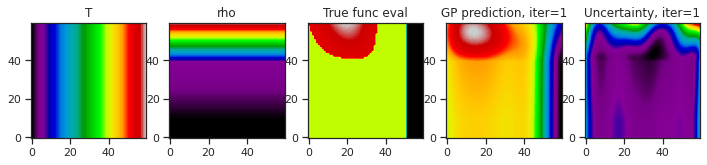

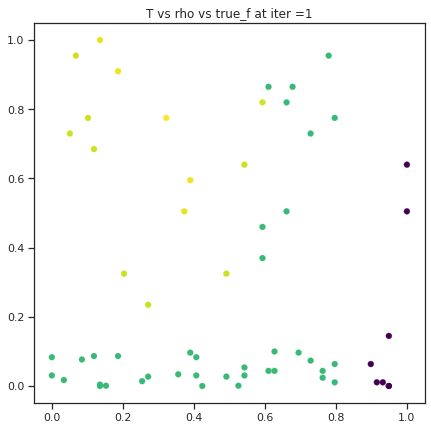

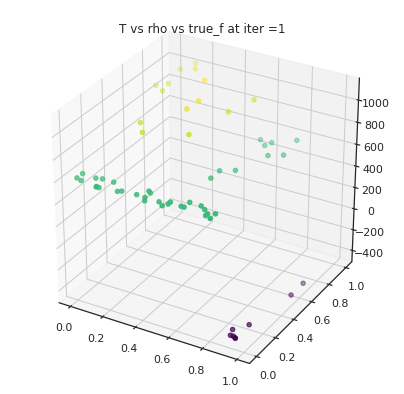

Model training:
Iteration:10
Loss:12952.432111735892
noise:1.8610902452376048
Model training:
Iteration:20
Loss:8424.783530408102
noise:2.795783468721228
Model training:
Iteration:30
Loss:6295.540759872489
noise:3.3597773215896156
Model training:
Iteration:40
Loss:5352.651375009167
noise:3.726503647013569
Model training:
Iteration:50
Loss:4893.952251411195
noise:4.014653886630694
Model training:
Iteration:60
Loss:4540.417653885028
noise:4.268526551941238
Model training:
Iteration:70
Loss:4272.375925348486
noise:4.4966976037513655
Model training:
Iteration:80
Loss:4057.081820047664
noise:4.704361814184112
Model training:
Iteration:90
Loss:3870.7737922851984
noise:4.898664340253122
Model training:
Iteration:100
Loss:3708.0011881817304
noise:5.085132567829693
Model training:
Iteration:110
Loss:3563.6983030294055
noise:5.266315644623538
Model training:
Iteration:120
Loss:3434.1851744894275
noise:5.4426734325833
Model training:
Iteration:130
Loss:3317.140567423088
noise:5.614071376351985
Mo

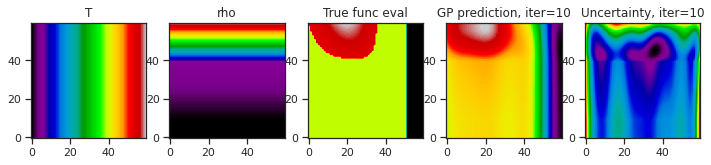

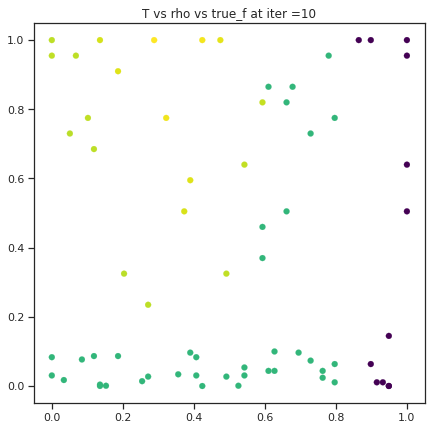

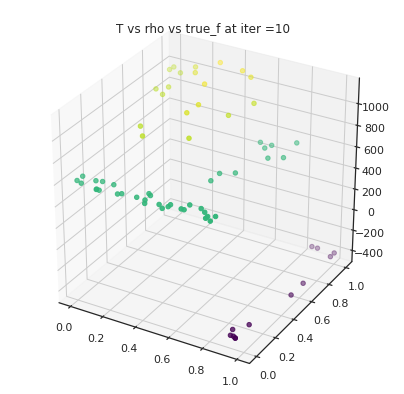

Model training:
Iteration:10
Loss:13409.502795584332
noise:1.8564645683495096
Model training:
Iteration:20
Loss:8663.201145132369
noise:2.804791568378602
Model training:
Iteration:30
Loss:6647.945437115577
noise:3.378192617577284
Model training:
Iteration:40
Loss:5613.859527970402
noise:3.7479134456307523
Model training:
Iteration:50
Loss:5106.792354705025
noise:4.039070301967731
Model training:
Iteration:60
Loss:4755.855748639437
noise:4.302289159982187
Model training:
Iteration:70
Loss:4475.631407070512
noise:4.548292500531677
Model training:
Iteration:80
Loss:4244.896757001245
noise:4.777760049044922
Model training:
Iteration:90
Loss:4049.5391830524495
noise:4.992200558002169
Model training:
Iteration:100
Loss:3878.66496567004
noise:5.194586415509881
Model training:
Iteration:110
Loss:3726.8371115313616
noise:5.388022590951494
Model training:
Iteration:120
Loss:3590.747767740663
noise:5.574857801445583
Model training:
Iteration:130
Loss:3467.824971197223
noise:5.756351938073438
Mode

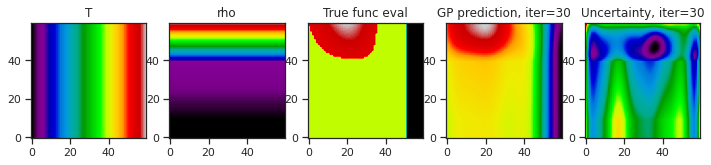

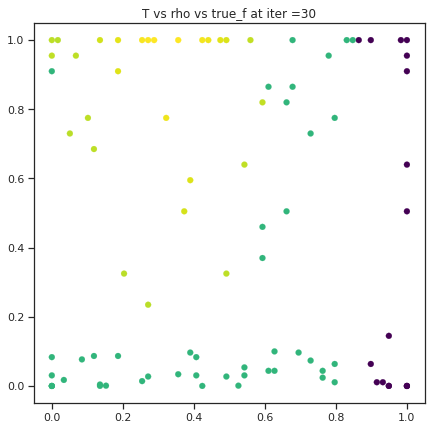

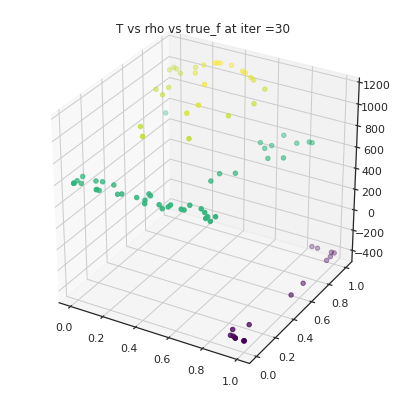

Model training:
Iteration:10
Loss:12354.068726348674
noise:1.8648285436585832
Model training:
Iteration:20
Loss:7990.339701848215
noise:2.859050029254758
Model training:
Iteration:30
Loss:6161.688850699042
noise:3.4906667583949127
Model training:
Iteration:40
Loss:5233.66719876745
noise:3.9064974986030667
Model training:
Iteration:50
Loss:4725.312264485001
noise:4.227944887288226
Model training:
Iteration:60
Loss:4396.692939682379
noise:4.513720120841937
Model training:
Iteration:70
Loss:4141.605055545439
noise:4.78297127852791
Model training:
Iteration:80
Loss:3928.2287437732643
noise:5.039035415874151
Model training:
Iteration:90
Loss:3746.335237259741
noise:5.281957360409336
Model training:
Iteration:100
Loss:3587.7484779829438
noise:5.51262217922336
Model training:
Iteration:110
Loss:3447.2514790191567
noise:5.732836710118995
Model training:
Iteration:120
Loss:3321.3760576086033
noise:5.944483067049562
Model training:
Iteration:130
Loss:3207.703301233181
noise:6.14901619383953
Mode

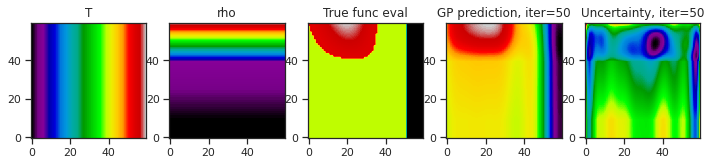

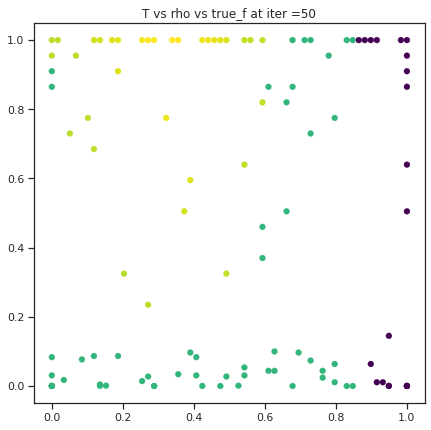

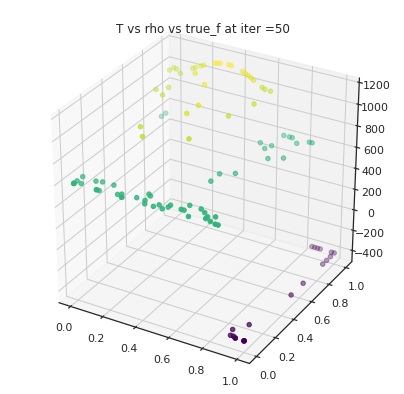

Model training:
Iteration:10
Loss:11866.882373831657
noise:1.8694390986485783
Model training:
Iteration:20
Loss:7577.512323815128
noise:2.8624196094633474
Model training:
Iteration:30
Loss:5911.415057273991
noise:3.479323826382106
Model training:
Iteration:40
Loss:5023.036760433927
noise:3.875602844387164
Model training:
Iteration:50
Loss:4538.579283960979
noise:4.177060868993404
Model training:
Iteration:60
Loss:4225.232943456414
noise:4.44435099193943
Model training:
Iteration:70
Loss:3979.4461540728407
noise:4.696291665194647
Model training:
Iteration:80
Loss:3774.2745701622466
noise:4.9356727288859155
Model training:
Iteration:90
Loss:3598.9943485424487
noise:5.162232145928714
Model training:
Iteration:100
Loss:3446.060987556457
noise:5.376592623173743
Model training:
Iteration:110
Loss:3310.6608247574627
noise:5.580396877907484
Model training:
Iteration:120
Loss:3189.327966952039
noise:5.775561303783
Model training:
Iteration:130
Loss:3079.7290399341623
noise:5.9637300560971385
Mo

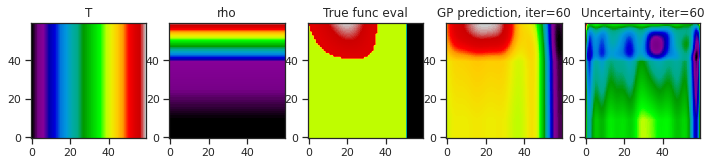

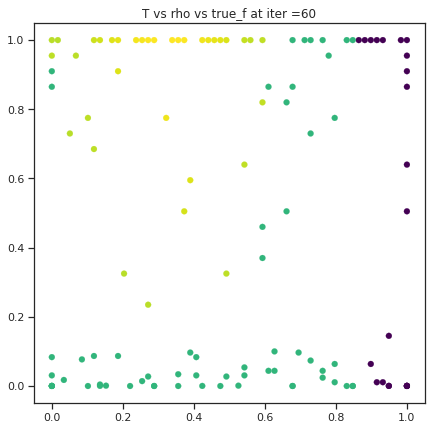

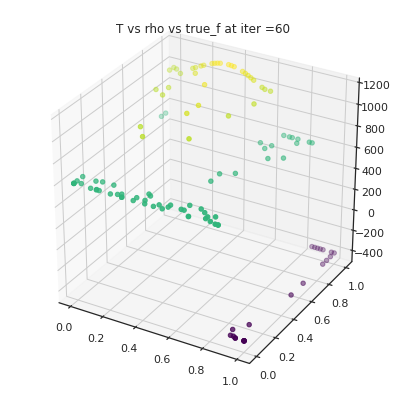

Model training:
Iteration:10
Loss:11438.64469392777
noise:1.8690863177439485
Model training:
Iteration:20
Loss:7219.1346141429385
noise:2.85066176213992
Model training:
Iteration:30
Loss:5648.466383966527
noise:3.4496667997971637
Model training:
Iteration:40
Loss:4781.965439776572
noise:3.8294689001594096
Model training:
Iteration:50
Loss:4329.785739813854
noise:4.116994710930379
Model training:
Iteration:60
Loss:4033.925516158938
noise:4.371871871817231
Model training:
Iteration:70
Loss:3795.2812288456544
noise:4.610275436886544
Model training:
Iteration:80
Loss:3598.525961885376
noise:4.833398209107797
Model training:
Iteration:90
Loss:3432.4423724791527
noise:5.0418001135398915
Model training:
Iteration:100
Loss:3287.233069764877
noise:5.238384166426354
Model training:
Iteration:110
Loss:3158.2359385789523
noise:5.42668048627948
Model training:
Iteration:120
Loss:3042.687376967632
noise:5.609108754666992
Model training:
Iteration:130
Loss:2938.3493773175865
noise:5.786706883320258
M

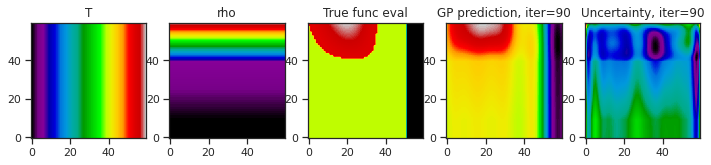

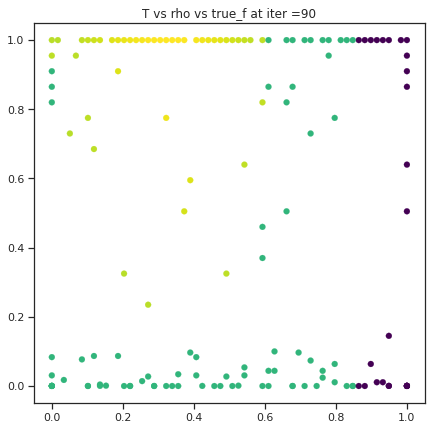

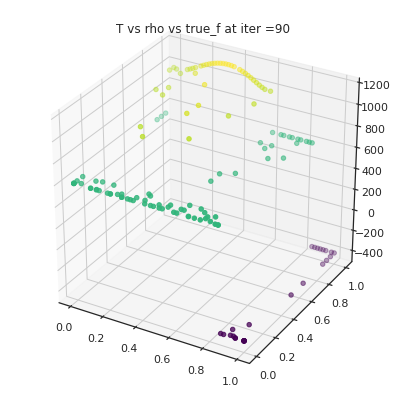

Model training:
Iteration:10
Loss:10489.146564736757
noise:1.8790717606404637
Model training:
Iteration:20
Loss:6492.915345613083
noise:2.8873196634311302
Model training:
Iteration:30
Loss:5108.541157308141
noise:3.506368582514694
Model training:
Iteration:40
Loss:4325.348336517819
noise:3.9003492027119573
Model training:
Iteration:50
Loss:3919.8168530083426
noise:4.19620859575812
Model training:
Iteration:60
Loss:3648.1655847529973
noise:4.454742347694888
Model training:
Iteration:70
Loss:3430.209567209143
noise:4.693039366944168
Model training:
Iteration:80
Loss:3254.009260632307
noise:4.914127788023914
Model training:
Iteration:90
Loss:3104.5860074096845
noise:5.121316442041961
Model training:
Iteration:100
Loss:2973.274158207065
noise:5.3191010700699595
Model training:
Iteration:110
Loss:2857.0775037275016
noise:5.510726354300384
Model training:
Iteration:120
Loss:2752.959342864111
noise:5.697406353426974
Model training:
Iteration:130
Loss:2658.8977614446894
noise:5.879248541358244

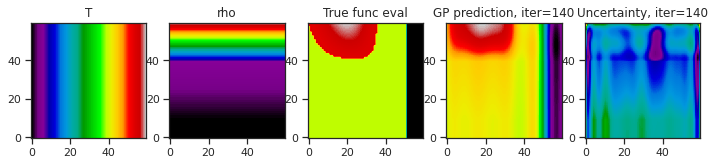

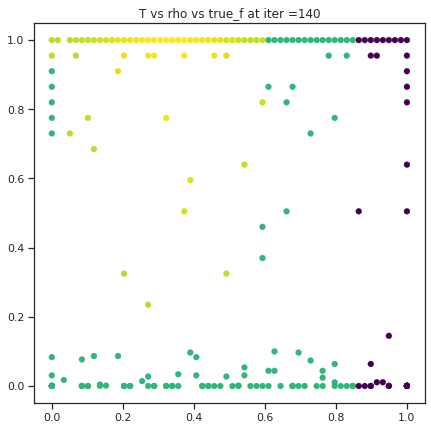

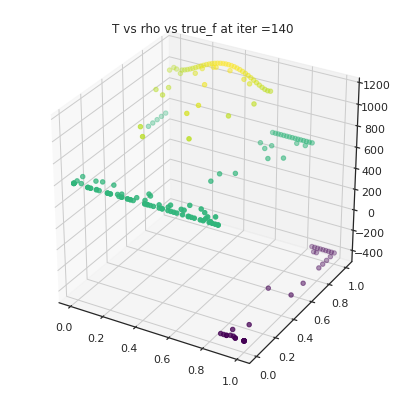

Model training:
Iteration:10
Loss:9441.919758113923
noise:1.8863487259800535
Model training:
Iteration:20
Loss:5491.726789298258
noise:2.89301300823446
Model training:
Iteration:30
Loss:4390.812462132549
noise:3.486097777436981
Model training:
Iteration:40
Loss:3669.9376041269365
noise:3.849827082990855
Model training:
Iteration:50
Loss:3321.5138192387535
noise:4.115203253864643
Model training:
Iteration:60
Loss:3093.4307410082347
noise:4.344925852937508
Model training:
Iteration:70
Loss:2910.213299237439
noise:4.5562354532714755
Model training:
Iteration:80
Loss:2765.465635388129
noise:4.752823650283822
Model training:
Iteration:90
Loss:2640.5607803820785
noise:4.939240207761038
Model training:
Iteration:100
Loss:2531.263829441891
noise:5.11972016800095
Model training:
Iteration:110
Loss:2434.2391062834786
noise:5.296156416481407
Model training:
Iteration:120
Loss:2347.0235418747507
noise:5.46863823085737
Model training:
Iteration:130
Loss:2268.100046379379
noise:5.636992980910079
Mod

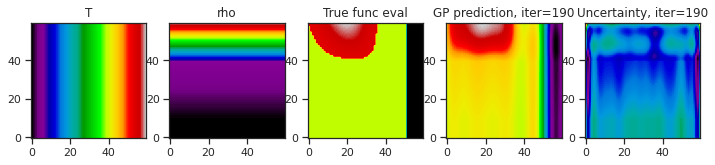

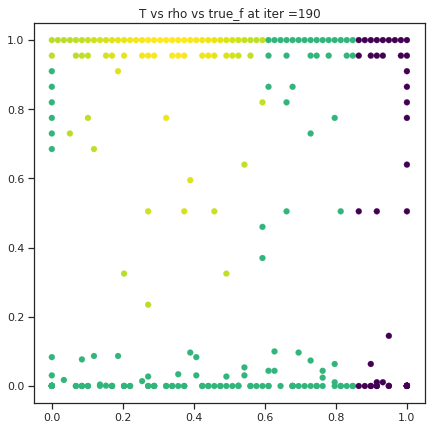

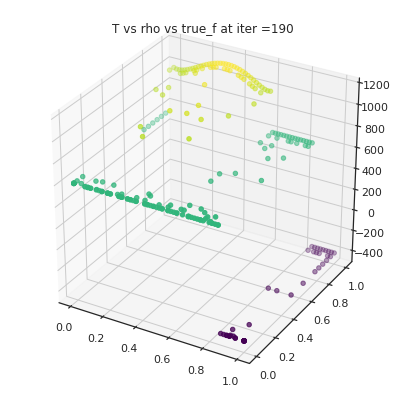

Model training:
Iteration:10
Loss:8754.580303095812
noise:1.8907066494493148
Model training:
Iteration:20
Loss:4870.848069405341
noise:2.8953404201686634
Model training:
Iteration:30
Loss:3946.718828818013
noise:3.4755568157427716
Model training:
Iteration:40
Loss:3282.5941899097106
noise:3.8258541553971477
Model training:
Iteration:50
Loss:2947.513794493025
noise:4.079132222449131
Model training:
Iteration:60
Loss:2758.1023123313826
noise:4.298555579217956
Model training:
Iteration:70
Loss:2595.642586407221
noise:4.503065028418845
Model training:
Iteration:80
Loss:2469.2981482572636
noise:4.69528924933396
Model training:
Iteration:90
Loss:2360.382224269242
noise:4.878160930026873
Model training:
Iteration:100
Loss:2264.288439316141
noise:5.055269460701341
Model training:
Iteration:110
Loss:2178.970829980648
noise:5.2286108049536955
Model training:
Iteration:120
Loss:2102.032020298893
noise:5.398443305887655
Model training:
Iteration:130
Loss:2032.2654268233448
noise:5.564500281268849


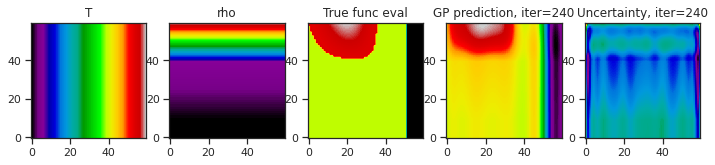

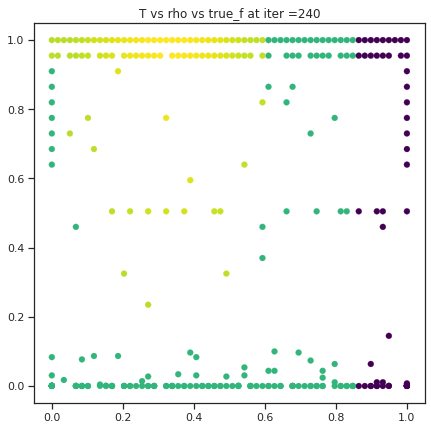

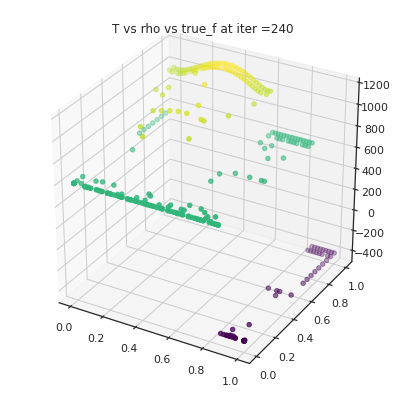

Model training:
Iteration:10
Loss:8057.261132386895
noise:1.8920945670056133
Model training:
Iteration:20
Loss:4387.993536642089
noise:2.896249431638803
Model training:
Iteration:30
Loss:3589.4086562925354
noise:3.472653383106024
Model training:
Iteration:40
Loss:3005.0244896207582
noise:3.816982405353377
Model training:
Iteration:50
Loss:2670.8164663069997
noise:4.064178155407894
Model training:
Iteration:60
Loss:2503.3733026609866
noise:4.278698569915431
Model training:
Iteration:70
Loss:2361.091989773311
noise:4.481858642722457
Model training:
Iteration:80
Loss:2245.0974663355287
noise:4.675834284970212
Model training:
Iteration:90
Loss:2147.753388663464
noise:4.860916627954381
Model training:
Iteration:100
Loss:2061.15593629541
noise:5.039343789475867
Model training:
Iteration:110
Loss:1983.9646712934548
noise:5.213313349384126
Model training:
Iteration:120
Loss:1914.4357233429894
noise:5.383752517208301
Model training:
Iteration:130
Loss:1851.2569063443455
noise:5.550654954298751


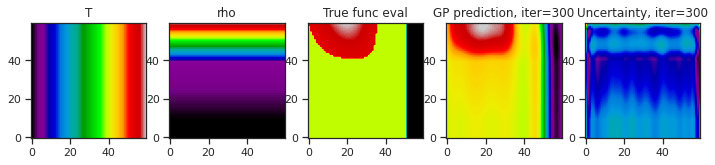

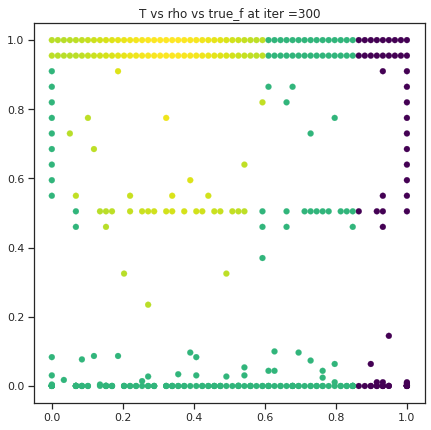

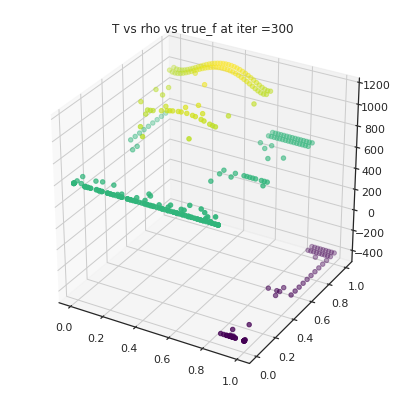

0.36312327
3.3392556


In [ ]:
w = [0.2, 0.4, 0.4]
# testresult = AFIsystem(350, 10**2, 50, 0.2, w)
# print(testresult)


num_rows = 60
num_rows1 = 10
num_rows2 = 31
num_rows3 = 21
num = 60  # Starting samples
N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
N = int(N)
T = np.linspace(300, 520, num_rows)
rho1 = np.linspace(10 ** 1, 10 ** 3, num_rows1)
rho2 = np.delete(np.linspace(10 ** 3, 10 ** 5, num_rows2),0)
rho3 = np.delete(np.linspace(10 ** 5, 10 ** 6, num_rows3),0)
rho = np.hstack((rho1, rho2, rho3))
minT = min(T)
maxT = max(T)
minrho = min(rho)
maxrho = max(rho)
T, rho = np.meshgrid(T, rho)
T_norm = (T-minT)/(maxT-minT)
rho_norm = (rho-minrho)/(maxrho-minrho)
# Below variables we need as we avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
test_T = np.linspace(300, 520, num_rows)
test_rho = np.hstack((rho1, rho2, rho3))
test_T, test_rho = np.meshgrid(test_T, test_rho)
testT_norm = (test_T-minT)/(maxT-minT)
testrho_norm = (test_rho-minrho)/(maxrho-minrho)

true_Y = to.empty(num_rows, num_rows)
f = np.zeros(1)
m = 0
for t1, (x1, x2) in enumerate(zip(T, rho)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        print("Lattice site #" + str(m + 1))
        #print(xx1)
        #print(xx2)
        h = 5
        dG = 0.2
        feval, solAP = AFIsystem2(xx1, xx2, h, dG, w)
        f[0] = feval
        true_Y[t1, t2] = to.from_numpy(f)
        m = m + 1

# Select starting samples randomly as training data
testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
np.random.seed(10)
ind_start = np.random.choice(len(testT_norm) - 1, size=num, replace=False)
t_y = np.reshape(true_Y, (num_rows ** 2, 1))
train_X = np.zeros((num, 2))
train_Y = np.zeros(num)
for i in range(0, num):
    train_X[i, 0] = testT_norm[ind_start[i]]
    train_X[i, 1] = testrho_norm[ind_start[i]]
    train_Y[i] = t_y[ind_start[i]]
    testT_norm[ind_start[i]] =-1
    testrho_norm[ind_start[i]] =-1

testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))

train_X = to.from_numpy(train_X)
train_X = train_X.double()
# train_X = train_X.unsqueeze(1)
train_Y = to.from_numpy(train_Y)
train_y = to.empty(train_Y.__len__(), 1)
train_y[:, 0] = train_Y

# Gp model fit
gp_PZO = SimpleCustomGP(train_X, train_y)
gp_PZO = gp_PZO.double()
gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
# fit_gpytorch_model(mll)
mll = mll.to(train_X)
gp_PZO.train()
gp_PZO.likelihood.train()

from torch.optim import SGD
from torch.optim import Adam
optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

NUM_EPOCHS = 150

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = gp_PZO(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, gp_PZO.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print("Model training:")
        print("Iteration:" + str(epoch + 1))
        print("Loss:" + str(loss.item()))
        # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
        print("noise:" + str(gp_PZO.likelihood.noise.item()))

    optimizer.step()

gp_PZO.eval()
gp_PZO.likelihood.eval()

for i in range(1, N + 1):
    ## Evaluating the posterior means and variances of the non-sampled lattice sites
    y_pred_means = to.empty(num_rows, num_rows)
    y_pred_vars = to.empty(num_rows, num_rows)
    for t1, (x1, x2) in enumerate(zip(testT_norm, testrho_norm)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2] = 0
                y_pred_vars[t1, t2] = 1e-6
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means[t1, t2] = y_pred_PZO.mean
                    y_pred_vars[t1, t2] = y_pred_PZO.variance

    if (i == 1 or i == 10 or i == 30 or i == 50 or i == 60 or i == 90 or i == 140 or i == 190 or i == 240):
        y_pred_means_full = to.empty(num_rows, num_rows)
        y_pred_vars_full = to.empty(num_rows, num_rows)
        for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
            for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y_pred_PZO = gp_PZO.posterior(test_X)
                    # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
                    y_pred_means_full[t1, t2] = y_pred_PZO.mean
                    y_pred_vars_full[t1, t2] = y_pred_PZO.variance

        t_x = train_X
        t_x = t_x.detach().numpy()
        t_x = np.reshape(t_x, (train_X.__len__(), 2))
        t_y = train_y
        t_y = t_y.detach().numpy()
        t_y = np.reshape(t_y, (train_X.__len__(), 1))
        # plot_exploration_results3D(test_T, test_rho, true_Y, y_pred_means, y_pred_vars, t_x, t_y, i)
        plot_exploration_results3D(T, rho, true_Y, y_pred_means_full, y_pred_vars_full, t_x, t_y, i)

    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    y_v = np.reshape(y_pred_vars, (num_rows ** 2, 1))
    acq_val = np.max(y_pred_vars)
    val = acq_val
    acq_cand = [k for k, j in enumerate(y_v) if j == acq_val]
    ind = np.random.choice(acq_cand)

    ## Find next point which maximizes the learning through exploration
    if (i == 1):
        val_ini = val
    # Check for convergence
    if ((val) <= 1e-5):  # Stop for negligible expected improvement
        print("Model converged due to sufficient reduction of uncertainty over search space ")
        break
    else:
        # Find the true P values of next X, augment to the training dataset
        nextX = to.empty(1, 2)
        next_feval = to.empty(1, 1)
        testT_norm = np.reshape(testT_norm, (num_rows ** 2, 1))
        testrho_norm = np.reshape(testrho_norm, (num_rows ** 2, 1))
        t_y = np.reshape(true_Y, (num_rows ** 2, 1))
        nextX[0, 0] = to.from_numpy(testT_norm[ind])
        nextX[0, 1] = to.from_numpy(testrho_norm[ind])
        testT_norm[ind] = -1
        testrho_norm[ind] = -1
        testT_norm = np.reshape(testT_norm, (num_rows, num_rows))
        testrho_norm = np.reshape(testrho_norm, (num_rows, num_rows))
        next_feval[:, 0] = t_y[ind]
        train_X = to.cat((train_X, nextX), 0)
        train_X = train_X.double()
        train_y = to.cat((train_y, next_feval), 0)

        # Updating GP model, conditioning on new data
        # Gp model fit
        gp_PZO = SimpleCustomGP(train_X, train_y)
        gp_PZO = gp_PZO.double()
        gp_PZO.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
        mll = ExactMarginalLogLikelihood(gp_PZO.likelihood, gp_PZO)
        # fit_gpytorch_model(mll)
        mll = mll.to(train_X)
        gp_PZO.train()
        gp_PZO.likelihood.train()

        optimizer = Adam([{'params': gp_PZO.parameters()}], lr=0.2)

        NUM_EPOCHS = 150

        for epoch in range(NUM_EPOCHS):
            # clear gradients
            optimizer.zero_grad()
            # forward pass through the model to obtain the output MultivariateNormal
            output = gp_PZO(train_X)
            # Compute negative marginal log likelihood
            loss = - mll(output, gp_PZO.train_targets)
            # back prop gradients
            loss.backward()
            # print every 10 iterations
            if (epoch + 1) % 10 == 0:
                print("Model training:")
                print("Iteration:" + str(epoch + 1))
                print("Loss:" + str(loss.item()))
                # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
                print("noise:" + str(gp_PZO.likelihood.noise.item()))

            optimizer.step()

        gp_PZO.eval()
        gp_PZO.likelihood.eval()

y_pred_means_full = to.empty(num_rows, num_rows)
y_pred_vars_full = to.empty(num_rows, num_rows)
for t1, (x1, x2) in enumerate(zip(T_norm, rho_norm)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        test_X = to.empty(1, 2)
        test_X[:, 0] = xx1
        test_X[:, 1] = xx2
        test_X = test_X.double()
        with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
             gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=True), \
             gpt.settings.max_cg_iterations(100), \
             gpt.settings.max_preconditioner_size(80), \
             gpt.settings.num_trace_samples(128):
            y_pred_PZO = gp_PZO.posterior(test_X)
            # y_pred_ferro = gp_ferrosim.likelihood(gp_ferrosim(test_X))
            y_pred_means_full[t1, t2] = y_pred_PZO.mean
            y_pred_vars_full[t1, t2] = y_pred_PZO.variance

P_pred_conv = (y_pred_means_full)
#P_var_cov = to.from_numpy(y_pred_vars)
P_var_cov = (y_pred_vars_full)
# Plots
t_x = train_X
t_x = t_x.detach().numpy()
t_x = np.reshape(t_x, (train_X.__len__(), 2))
t_y = train_y
t_y = t_y.detach().numpy()
t_y = np.reshape(t_y, (train_X.__len__(), 1))
plot_exploration_results3D(T, rho, true_Y, P_pred_conv, P_var_cov, t_x, t_y, i)
if (i == N + 1):
    print("Max. sampling reached, model stopped")
print(val)
print(val_ini)

<h1> Observation

Total grid points is 3600, and we stop our GP exploration after using 360 sample points (10% utilization). The GP prediction is done based on 360 adaptively selected (full exploration) samples.

In the true image (middle figure),
Black region is the PE phase, yellow region is the AFE phase and red/white region is the FEI phase. In the FEI phase, red region is the area having deeper wells at A and as the objective value increases (with color changing from red to white), we are approaching towards deeper wells at P. The domain does not have AFI phase

In the GP predicted image (4th figure), we can see similar distinctive region with different color coding and thus gave us the interpretation of individual phases. We can have better prediction of phases with more advanced aquistion function (exploration -exploitation) to sample where the objective function is higher.

**We see as $h$ decreases, the AFE phase region increases for the same domain area- compare Analysis 4 with 1**